In [3]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2.5 * matplotlib.rcParams['savefig.dpi']
from matplotlib import pylab as plt

In [4]:
import numpy as np
import pandas as pd

import statsmodels.tsa.api as smt
from arch import arch_model
import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as scs
from scipy import linalg

In [5]:
from statsmodels.tsa.stattools import acf as sm_acf
from statsmodels.tsa.stattools import acovf as sm_acovf
from statsmodels.tsa.stattools import pacf as sm_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as sm_acorr_ljungbox

# Time Series Analysis

In this notebook, I will work through some models from univariate time series analysis, and apply them to simulated and real datasets. I'll start with i.i.d. white noise, and gradually extend the concepts up to conditional volatility analysis with GARCH models.

### Introduction

In supervised machine learning, the objective is to discover relationships between independent and dependent variables in a set of example data, so that one can generate useful predictions for data yet unseen. Although we may observe a great deal of variability from one sample to the next (noise), we are interested in capturing whatever reproducible behavior might persist as a general rule across all samples (signal). The process involves collecting and sorting data into at least two categories: 1) data that will be used to inform model development and 2) data that will be used to evaluate the model. In the most basic case, we should assemble a training set and a test set.

Textbook examples often create training and test sets by randomly splitting an existing dataset. This approach has some advantages, chief among them the lack of sample bias. Since the training and test sets were randomly selected from the same batch of data, one can be confident that the fundamental relationships between variables underlying both datasets are identical. In the real world, however, it is not always practical to split your data randomly. Time series are one example.

### Time Series Basics

Consider the case of stock price forecasting. Knowing today's price, and in fact the entire history of prices, what can we predict about tomorrow's price? The day after? Can we learn anything at all useful about future prices, given what we know presently? These questions have given rise to the field known as time series analysis.

A time series is a vector of observations, with each observation corresponding to a point in time. Examples include quarterly revenues for a restaurant, the daily high temperature reading at your local airport, an air quality monitor recording hourly NO2 measurements near a freeway, and of course a history of stock daily closing prices. The time intervals are often regular, although this does not need to be the case; for instance, a stock price time series will only include non-holiday weekends when the exchange is open.


### Discrete White Noise

Let's consider a time series of i.i.d. standard normal random variables:

In [6]:
import numpy as np

np.random.seed(2)
ser_0 = np.random.normal(size=1000)

In [7]:
# Here is a useful visualization function for time series
    # adapted from http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax,linestyle='none',marker='o',markersize=4)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

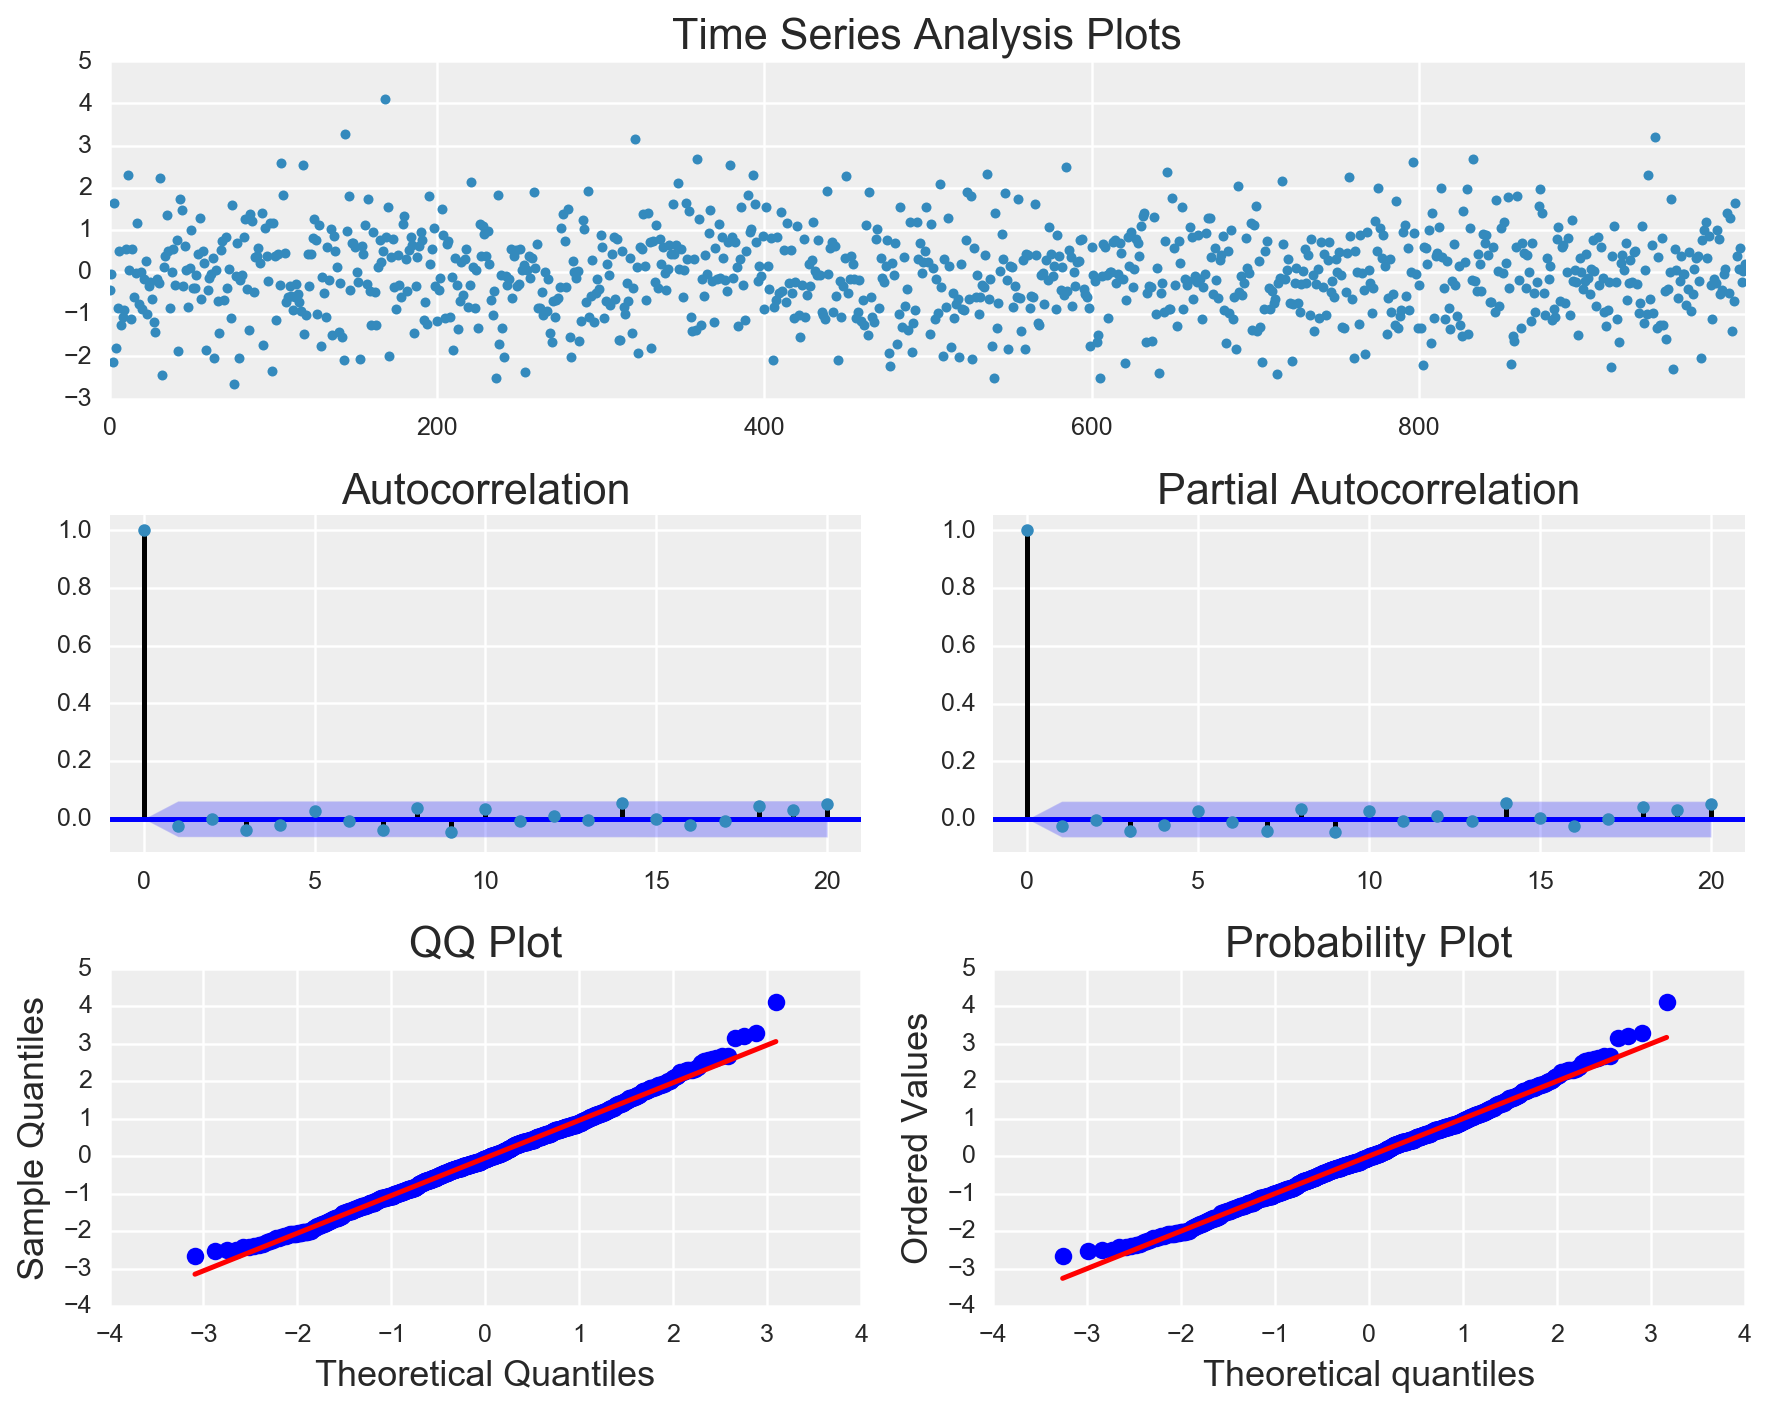

In [8]:
tsplot(ser_0, lags=20)

Successive terms in the TS are independent. The scatterplot below will show uncorrelated randomness for all values of $dt \neq 0$ .

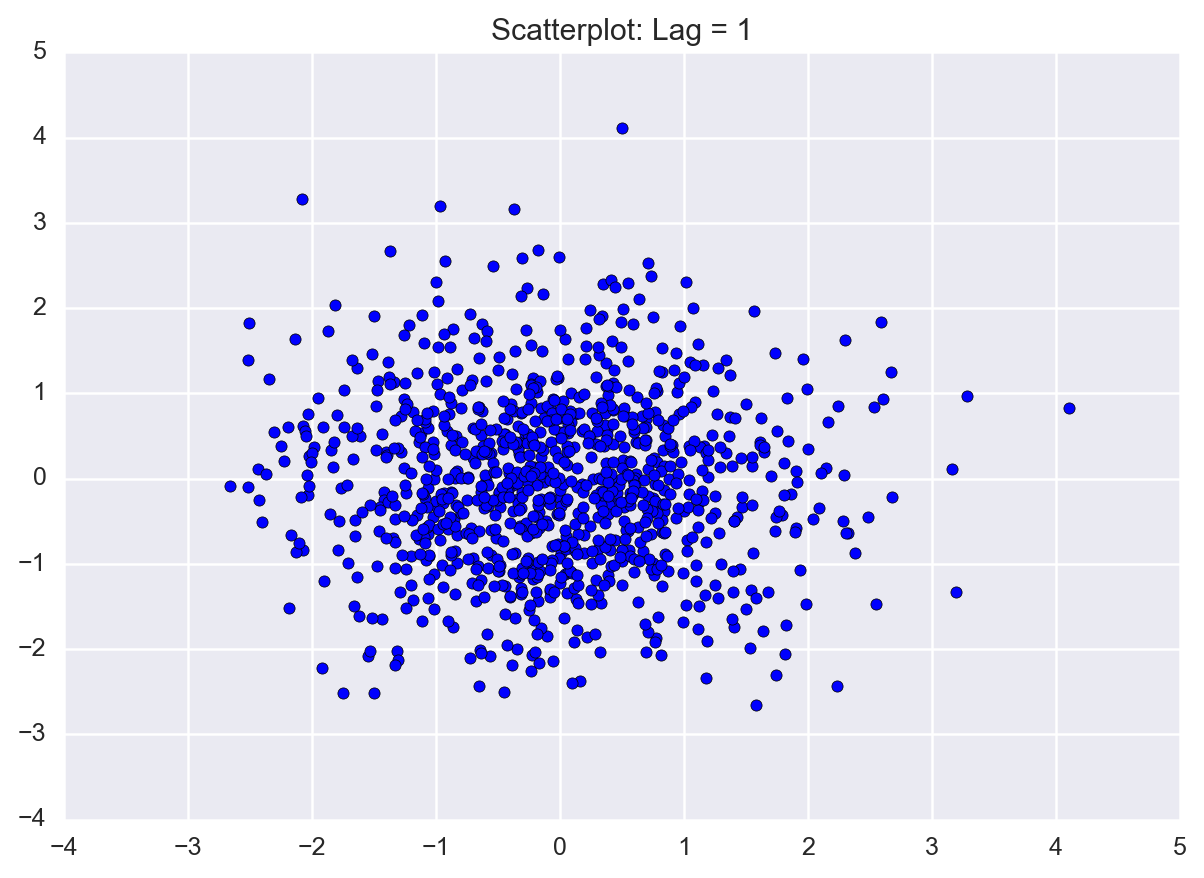

In [10]:
dt=1
X = ser_0[:(-dt or None)]
Y = ser_0[(dt):]
plt.scatter(X,Y)
plt.title('Scatterplot: Lag = %d' % dt)

### Correlation



Correlation of two variables quantifies the predictive power of any linear relationship that may exist between the two.
$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\sd}{\mathrm{sd}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\DeclareMathOperator{\sign}{sign}$

We begin by defining the covariance between two random variables $X$ and $Y$ as
$$\Cov(X,Y) \equiv \E(XY) - \E(X)\E(Y)$$

We note some immediate consequences of this definition:

1. $\Cov(X,X) = \Var(X)$
1. $\Cov(a X,b X) = a \ b \ \Var(X)$
1. $\Cov(X,Y) = 0$ if $X$ and $Y$ are independent

The first two observations show that the magnitude of covariance scales with the data. We desire a dimensionless metric, so define: 
$$\rho(X,Y) \equiv \frac{\Cov(X,Y)}{\sigma_{X} \sigma_{y}}$$
where $\sigma_{X} = \sd(X) = \sqrt{\Var(X)}$.

Now 

1. $\rho(X,X) = 1$
1. $\rho(a X, b X) = \sgn(ab)$
1. $\rho(X,Y) = 0$ if $X$ and $Y$ are independent

### Auto-Correlation

In time series analysis, we are interested in the relationships between successive observations in a single quantity. The concepts of covariance and correlation extend naturally to time series:

$$\Cov(X_{t},X_{t-k}) \equiv \E(X_{t}X_{t-k}) - \E(X_{t})\E(X_{t-k}) = \E(X_{t}X_{t-k}) - [\E(X)]^2$$

$$\rho_h(X) = (X_{t},X_{t-h}) \equiv \frac{\Cov(X_{t},X_{t-h})}{\sigma_{X_{t}} \sigma_{X_{t-h}}} = \frac{\Cov(X_{t},X_{t-h})}{[\sigma_{X}]^2}$$

Here, $h$ refers to the delta in time steps. The notation for autocorrelation function is often simplified to $\rho(h)$.

In real data we won't know the underlying distribution exactly, so we must deal with samples. The sample auto-covariance function is:
$$\hat{\gamma}(h) \equiv \frac{1}{n-h} \; \sum_{j=h+1}^{n} (X_j - \hat{\mu})*(X_{j-h} - \hat{\mu}) \hspace{3em} \textrm{unbiased version}$$
$$\hat{\gamma}(h) \equiv \frac{1}{n} \; \sum_{j=h+1}^{n} (X_j - \hat{\mu})*(X_{j-h} - \hat{\mu}) \hspace{3em} \textrm{biased version}$$
where $n$ is the total number of samples and $\hat{\mu}$ is the sample mean $\bar{X}$.

In [12]:
# write my own acf:
def rek_acf(series,lags=5,unbiased=True): 
    n=len(series)
    autocorrelations = np.zeros(1+lags)
    series = series-np.mean(series)  # DEMEAN
    for lag in range(0,1+lags):
        X = series[:(-lag or None)]
        Y = series[(lag):]
        assert(len(X)==len(Y))
        covXY = np.mean(X*Y) - (np.mean(series))**2
        corXY = covXY / (np.var(series))
        # Note that covXY and corXY get mean and var from full series, not from mean(X)*mean(Y)
        if (unbiased==False):
            corXY *= (n-lag)/float(n)
        autocorrelations[lag] = corXY
    return autocorrelations

In [14]:
print(rek_acf(ser_0,lags=10,unbiased=True))
print(rek_acf(ser_0,lags=10,unbiased=False))

[ 1.         -0.02369908 -0.00170053 -0.04028983 -0.02023877  0.02788191
 -0.00875924 -0.04079471  0.0366087  -0.04755215  0.033672  ]
[ 1.         -0.02367538 -0.00169713 -0.04016896 -0.02015782  0.0277425
 -0.00870669 -0.04050915  0.03631583 -0.04712418  0.03333528]


In [16]:
print(rek_acf(ser_0,lags=30,unbiased=True)/sm_acf(ser_0,unbiased=True,nlags=30))
print(rek_acf(ser_0,lags=30,unbiased=False)/sm_acf(ser_0,unbiased=False,nlags=30))
# Verified: Matches the statsmodels version

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Why two versions of the ACF?

There is no universal convention for the denominator. The ACF with $n$ in the denominator is always biased. But the ACF with $n-h$ in the denominator, which may appear to be unbiased due to there being $n-h$ terms in the sum,  is often not unbiased either (i.e. whenever the population mean is unknown and a sample mean is used to estimate it). So a blanket referral to this version as unbiased is inaccurate. Nevertheless, the word 'unbiased' is often used to describe this version. It turns out that the biased version is used more commonly, because it has useful statistical properties.

Regardless, for $h << n$, these two versions converge to each other. For most analysts investigating datasets to learn about variables of interest, it will not matter which version is used.

More information on the topic of biased vs. unbiased ACF:
1. [statsmodels' doc](http://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#acf)
1. [NIST/SEMATECH e-Handbook of Statistical Methods](http://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm)
1. [The Analysis of Time Series - An Introduction. 6th ed. Chris Chatfield](https://github.com/zixiaojindao/time-series-survey/blob/master/time%20series/The%20Analysis%20of%20Time%20Series%20-%20An%20Introduction%206ed_Chris%20Chatfield.pdf)


In [19]:
# ratio between biased and unbiased versions = (n-k)/n
# (bias increases as lag increases)

### Ljung-Box test:

The sample auto-correlation of an i.i.d. random process auto-correlations will not be exactly zero due to noise. One may encounter a time series and wish to assess whether the observed sample auto-correlation is due to signal (an underlying property of the process that generated the dataset) or noise (random variation). Thus it is useful to devise a statistical test to answer this question. 

It is desirable to consider the entire ACF in such a test, because a signal departure from uncorrelated noise could occur at any lag. Thus Ljung and Box devised a portmanteau test that would consider all lags from unity up to a specific maximum. The null hypothesis $H_0$ is that the underlying process is i.i.d; the Ljung-Box test statistic 

$$Q(k) = n (n+2) \sum_{j=1}^k \frac{{\rho_j}^2}{n-j} $$

for the first $k$ lags follows a chi-square distribution if null hypothesis is true. The associated p-value from the chi-square distribution indicates the likelihood of obtaining a Q greater than or equal to the observed value if the true distribution were in fact uncorrelated noise.

In [25]:
        # G. M. Ljung; G. E. P. Box (1978). "On a Measure of a Lack of Fit in Time Series Models". 
                # Biometrika. 65 (2): 297–303.  https://doi.org/10.1093%2Fbiomet%2F65.2.297
def rek_LjungBox(series,lags):
    n=len(series)
    jj = np.arange(1,1+lags) # lags
    Q_jj = n*(n+2) * ((rek_acf(series,lags,unbiased=False)[1:])**2) / (n-jj)
    Q = np.cumsum(Q_jj)
    pValues = 1-scs.chi2.cdf(Q,jj)
    return (Q,pValues)

In [23]:
# statsmodels uses the biased acf for its Ljung-Box computation

In [24]:
rek_LjungBox(ser_0,lags=30)

(array([  0.56220709,   0.5650989 ,   2.18673599,   2.59552133,
          3.37058234,   3.44699887,   5.10286315,   6.43499741,
          8.68033506,   9.80504541,   9.86834628,   9.96450935,
          9.99372364,  12.97286198,  12.97371521,  13.45110591,
         13.52734342,  15.39018782,  16.31886651,  19.09646588,
         23.15537021,  23.26676638,  23.38514664,  24.13050465,
         24.13413151,  27.24317634,  27.60585145,  27.60647087,
         27.8146555 ,  28.812571  ]),
 array([ 0.45337234,  0.75385936,  0.53456569,  0.62761671,  0.6430541 ,
         0.75100739,  0.64741185,  0.59862642,  0.46728977,  0.45776074,
         0.54226704,  0.61907435,  0.69444753,  0.52866162,  0.60432825,
         0.63953252,  0.70023097,  0.63502423,  0.63590832,  0.51556381,
         0.33575064,  0.38679956,  0.43847785,  0.45415522,  0.51163439,
         0.3966688 ,  0.43150335,  0.48544064,  0.52783879,  0.52745813]))

In [27]:
sm_acorr_ljungbox(ser_0,lags=30)

(array([  0.56220709,   0.5650989 ,   2.18673599,   2.59552133,
          3.37058234,   3.44699887,   5.10286315,   6.43499741,
          8.68033506,   9.80504541,   9.86834628,   9.96450935,
          9.99372364,  12.97286198,  12.97371521,  13.45110591,
         13.52734342,  15.39018782,  16.31886651,  19.09646588,
         23.15537021,  23.26676638,  23.38514664,  24.13050465,
         24.13413151,  27.24317634,  27.60585145,  27.60647087,
         27.8146555 ,  28.812571  ]),
 array([ 0.45337234,  0.75385936,  0.53456569,  0.62761671,  0.6430541 ,
         0.75100739,  0.64741185,  0.59862642,  0.46728977,  0.45776074,
         0.54226704,  0.61907435,  0.69444753,  0.52866162,  0.60432825,
         0.63953252,  0.70023097,  0.63502423,  0.63590832,  0.51556381,
         0.33575064,  0.38679956,  0.43847785,  0.45415522,  0.51163439,
         0.3966688 ,  0.43150335,  0.48544064,  0.52783879,  0.52745813]))

In [96]:
# Verified: My Ljung-Box computation matches statsmodels

# The input data set is white noise, so not surprising:
            # the p-values are close to the middle of what would be expected for white noise
            # so L-B Test fails to reject H0 (H0= white noise hypothesis)


This input data set is white noise, so the result is not surprising. The p-values are close to the middle of what should be expected for white noise. L-B Test clearly fails to reject $H_0$ at a 5% level of significance.

In [97]:
# What values of LB test statistic would have been necessary in order to hit alpha=0.05 and reject H0?
                    # (as a separate function of each lag)
alpha = 0.05
numLags = 30
scs.chi2.ppf(1-alpha,np.arange(1,1+numLags))

array([  3.84145882,   5.99146455,   7.8147279 ,   9.48772904,
        11.07049769,  12.59158724,  14.06714045,  15.50731306,
        16.9189776 ,  18.30703805,  19.67513757,  21.02606982,
        22.36203249,  23.6847913 ,  24.99579014,  26.2962276 ,
        27.58711164,  28.86929943,  30.14352721,  31.41043284,
        32.67057334,  33.92443847,  35.17246163,  36.4150285 ,
        37.65248413,  38.88513866,  40.11327207,  41.33713815,
        42.5569678 ,  43.77297183])

In [98]:
# When many different white noise series are fed into LB test, the output p-values should be uniformly distributed on (0,1)
# For a given series there is a high correlation between pVal at lag i vs. pVal at lag j
                        # (duh, it uses the same data, and there is a cumsum)
# But for many runs of the LB test on different white-noise series, the pValues at any given lag should be unif dist

# Let's test this (RT: 5sec)

N = 10000 # runs
seriesLength = 1000 
nLags = 30 # lags
pValues = np.zeros((N,nLags))
randomMatrix = scs.norm.rvs(size=(N,seriesLength))
for run in range(N):
    mySeries = randomMatrix[run]
    assert(len(mySeries)==seriesLength)
    (_,thisP) = sm_acorr_ljungbox(mySeries,lags=30)
    pValues[run,:] = thisP

In [99]:
pValues
# correlation within each resultant Q vector is obvious

array([[ 0.70740191,  0.92445726,  0.98368809, ...,  0.86009616,
         0.82575044,  0.85265291],
       [ 0.31568064,  0.51137101,  0.57928519, ...,  0.16663896,
         0.17564066,  0.20946586],
       [ 0.92112582,  0.96600578,  0.8232333 , ...,  0.48153352,
         0.49744734,  0.49874918],
       ..., 
       [ 0.6631827 ,  0.81417895,  0.92114168, ...,  0.64258304,
         0.66030184,  0.68287343],
       [ 0.00348791,  0.00684053,  0.01376869, ...,  0.01002077,
         0.01225521,  0.00993659],
       [ 0.49716991,  0.10027461,  0.14795154, ...,  0.01215993,
         0.01561399,  0.01873433]])

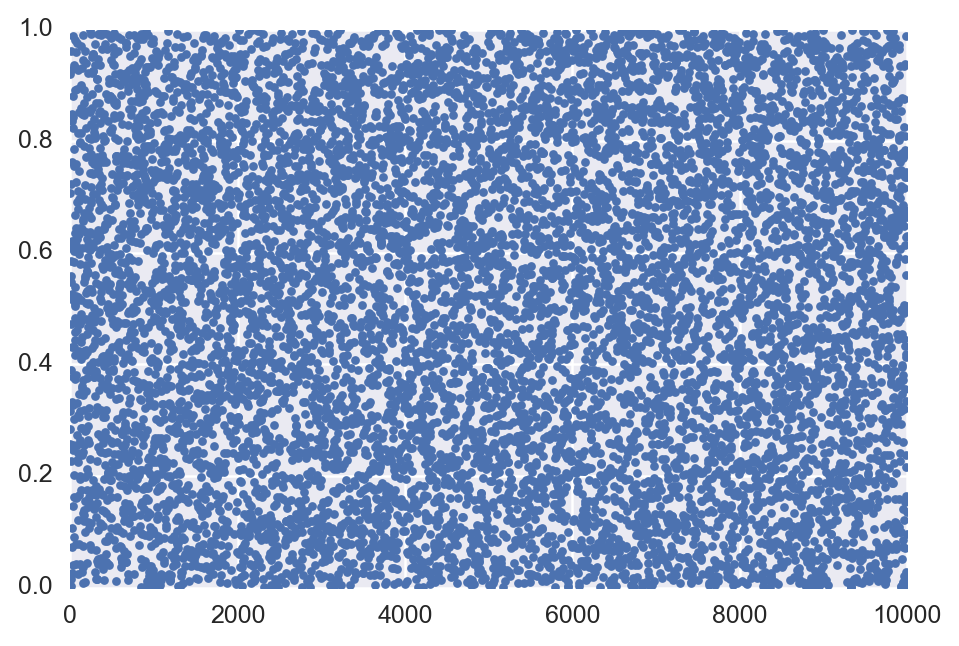

In [102]:
# But for a given lag, the distribution of pValues across separate runs looks uniform !

plt.plot(pValues[:,0],'.')  # index 0 ==> lag=1

In [103]:
# Consider an AR(1) process:

In [104]:
def rek_generateSeries_AR1(n,mu,phi):
    epsilon=np.random.normal(size=n)
    ser = np.zeros(n) # just preAllocating space
    ser[0] = mu + epsilon[0]
    for i in range(1,n):
        ser[i] = mu + phi*(ser[i-1]-mu) + epsilon[i] 
    return ser

In [105]:
np.random.seed(28)
ser_AR1 = rek_generateSeries_AR1(1000,0.0,0.95)

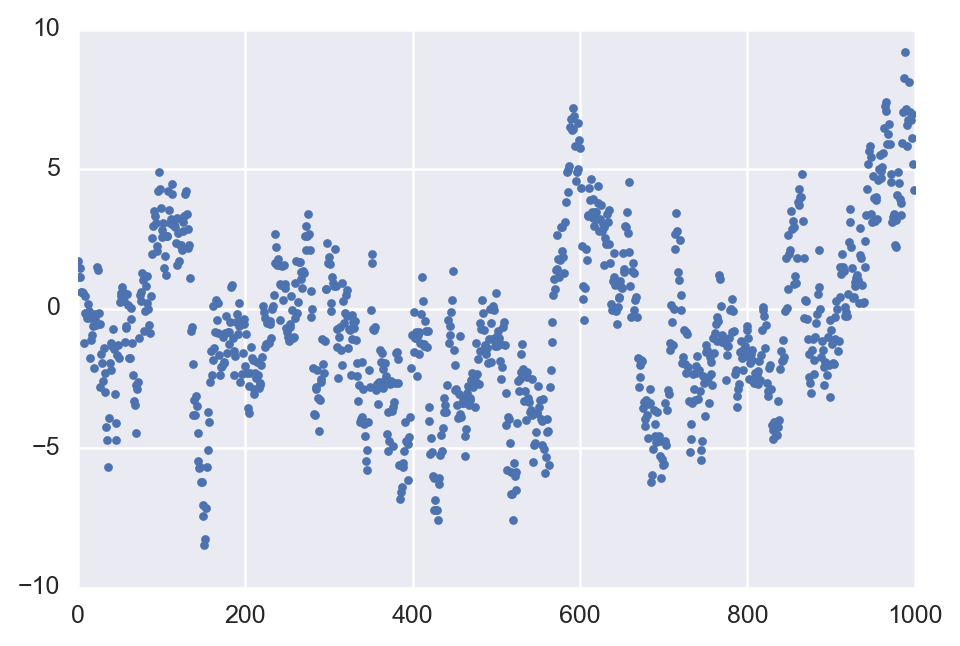

In [106]:
np.random.seed(7)
ser_AR1_seed7 = rek_generateSeries_AR1(1000,0.0,0.95)
plt.plot(ser_AR1_seed7,'.')

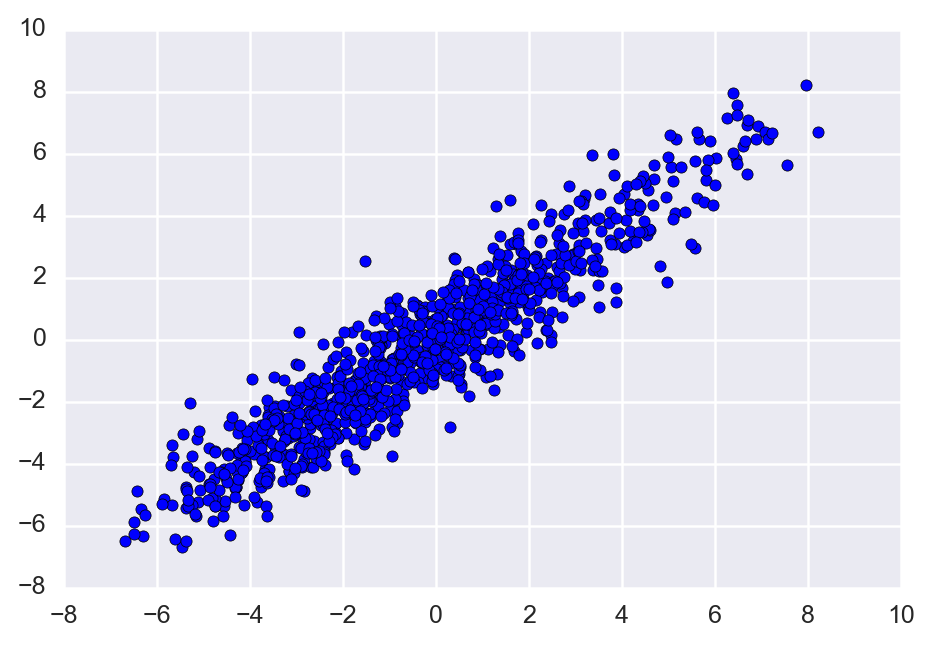

In [107]:
plt.scatter(ser_AR1[:-1],ser_AR1[1:])

In [114]:
# OLS linear regression: Y = beta*X + eps 
        # where the X term includes an X_0 === 1 (so beta_0 is intercept)
        # eps is the noise term

np.random.seed(28)
order=1
(n,mu,phi) = (100000,0.0,0.95)
ser_AR1 = rek_generateSeries_AR1(n,mu,phi)
(X,Y) = (ser_AR1[:-order].reshape(n-order,1),ser_AR1[order:].reshape(n-order,1))
xX = np.concatenate((np.ones((X.shape[0],1)),X),axis=1) # add an intercept term, (it's a trivial feature vector: all ones)
beta = np.dot(np.linalg.inv(np.dot(xX.T,xX)),np.dot(xX.T,Y)) # matrix computation for exact solution to OLS linear regression
print(beta)

[[-0.00440265]
 [ 0.95058421]]


In [115]:
print(rek_acf(ser_AR1,lags=4,unbiased=True))
print(rek_acf(ser_AR1,lags=4,unbiased=False))
print(sm_acf(ser_AR1,nlags=4,unbiased=True))
print(sm_acf(ser_AR1,nlags=4,unbiased=False))

[ 1.          0.950559    0.90364444  0.85881738  0.81626509]
[ 1.          0.9505495   0.90362637  0.85879162  0.81623244]
[ 1.          0.950559    0.90364444  0.85881738  0.81626509]
[ 1.          0.9505495   0.90362637  0.85879162  0.81623244]


In [116]:
# (pd.Series(ser_AR1)).to_csv('serar1_028.csv')    # we will look at the same data in RStudio
#R: acf28 = acf(serar1,lag.max=4,plot=FALSE,demean=TRUE)
    # [1,] 1.00000000
    # [2,] 0.95054950
    # [3,] 0.90362637
    # [4,] 0.85879162
    # [5,] 0.81623244
# So R's stats::acf function is using "unbiased=FALSE" (it does not offer an option for unbiased=TRUE)
            # perhaps due to the observations in Chatfield, etc. (same references as in the cell above)
                                    # http://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm
                                    # https://github.com/zixiaojindao/time-series-survey/blob/master/time%20series/
                                    # The%20Analysis%20of%20Time%20Series%20-%20An%20Introduction%206ed_Chris%20Chatfield.pdf
                                            # section 4.1: the biased estimator is positive-semidefinite, useful for FFTs

In [113]:
rek_LjungBox(ser_AR1,lags=30)
#sm_acorr_ljungbox(ser_AR1,lags=30)
        # these two calculations match exactly (although sm is slower b/c it computes entire acf before truncating!)
    
# L-B test leads to Enormous Q-statistic and zero p-values: obviously not white noise!

(array([  90357.14543584,  172014.47298779,  245770.46540532,
         312398.00220357,  372563.13962378,  426876.7913397 ,
         475975.39445202,  520357.53568758,  560426.81133926,
         596611.90768369,  629262.84020088,  658714.55443201,
         685339.36676728,  709439.44425767,  731226.40389786,
         750914.05765103,  768741.02628347,  784882.13278889,
         799509.55585353,  812769.07909608,  824733.03991588,
         835525.20220697,  845274.32251859,  854099.07750983,
         862068.99995483,  869250.23088637,  875739.86242039,
         881596.41149872,  886878.64561699,  891629.86561879]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]))

In [117]:
# tsplot(ser_AR1,lags=30)

In [118]:
# Now let's subtract out the regression fit to the series. We want to see if the residuals look like white noise:
         # using regression fit parameters, not the underlying mu and phi that generated the series:
Z = Y - np.dot(xX,beta)
# plt.plot(Z,'.')  # looks like white noise
rek_LjungBox(Z,lags=30) # Q-statistic is low and p-values are large, so we would not reject H0

(array([  0.06301794,   0.59961235,   0.63949713,   0.81290757,
          0.87805186,   3.47589832,   3.48687452,   5.09666638,
          5.19733638,   5.65931523,   5.70319007,   9.39745972,
         10.29132351,  11.39535679,  11.49721418,  13.32250792,
         13.34960869,  13.5100235 ,  13.51097673,  20.70561977,
         20.70977277,  21.29360844,  22.14176351,  23.37305362,
         24.24660815,  25.89265134,  26.16222108,  26.19446974,
         26.88752467,  26.90743014]),
 array([ 0.80178802,  0.74096182,  0.88733382,  0.9367093 ,  0.97179021,
         0.74717351,  0.83661376,  0.74719611,  0.81677775,  0.84302809,
         0.89241619,  0.66865926,  0.6699559 ,  0.65473644,  0.7166177 ,
         0.64904696,  0.71248556,  0.76042809,  0.81141667,  0.41463798,
         0.47678646,  0.50266143,  0.51170777,  0.49787469,  0.50516332,
         0.46901769,  0.5096118 ,  0.56235587,  0.57777349,  0.62812786]))

In [119]:
# Look at the acf of the residuals. Is that the same thing as pacf?

In [120]:
print(rek_acf(Z,lags=5,unbiased=True))
print(rek_acf(Z,lags=5,unbiased=False))
print(sm_acf(Z,nlags=5, unbiased=True))
print(sm_acf(Z,nlags=5, unbiased=False))

[  1.00000000e+00  -7.93838420e-04   2.31646233e-03  -6.31550286e-04
   1.31687375e-03   8.07136294e-04]
[  1.00000000e+00  -7.93830481e-04   2.31641600e-03  -6.31531339e-04
   1.31682107e-03   8.07095937e-04]
[  1.00000000e+00  -7.93838420e-04   2.31646233e-03  -6.31550286e-04
   1.31687375e-03   8.07136294e-04]
[  1.00000000e+00  -7.93830481e-04   2.31641600e-03  -6.31531339e-04
   1.31682107e-03   8.07095937e-04]


In [121]:
print(sm_pacf(ser_AR1,nlags=5,method='ywunbiased'))
print(sm_pacf(ser_AR1,nlags=5,method='ywmle'))
print(sm_pacf(ser_AR1,nlags=5,method='ols'))   # sm documentation claims there is an error with pacf ols ?
print(' ')
print(sm_acf(ser_AR1,nlags=4,unbiased=True))
print(sm_acf(ser_AR1,nlags=4,unbiased=False)) 

[  1.00000000e+00   9.50559003e-01   8.50520485e-04  -2.36293068e-03
   5.25481545e-04  -1.52420046e-03]
[  1.00000000e+00   9.50549498e-01   8.50343194e-04  -2.36241814e-03
   5.25362025e-04  -1.52384078e-03]
[  1.00000000e+00   9.50584207e-01   8.34218152e-04  -2.35237878e-03
   5.02187944e-04  -1.47823696e-03]
 
[ 1.          0.950559    0.90364444  0.85881738  0.81626509]
[ 1.          0.9505495   0.90362637  0.85879162  0.81623244]


In [122]:
# No. The autocorrelation of the residuals is not the same as pacf, even in the lag=2 term.
    # The lag=1 term does match
            # PACF ywunbiased at lag=1 matches ACF unbiased at lag=1
            # PACF ywmle at lag=1 matches ACF biased at lag=1

# pacf at lag2 is (E(X0*X2 | X1)) / (sd(X0|X1)*sd(X2|X1)) 

In [123]:
print(sm_acf(ser_AR1,nlags=1,unbiased=True)[1],sm_pacf(ser_AR1,nlags=1,method='ywunbiased')[1])
print(sm_acf(ser_AR1,nlags=1,unbiased=False)[1],sm_pacf(ser_AR1,nlags=1,method='ywmle')[1])
# The lag=1 terms do agree perfectly 

(0.95055900338426547, 0.95055900338426547)
(0.9505494977942317, 0.9505494977942317)


In [45]:
# Let's follow the Yule-Walker method and reproduce pacf:
    # https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula
    
def rek_pacf(series,lags=5,unbiased=True):
            # let this function do both yule-walker pacfs: (unbiased=>ywunbiased, biased=>ywmle)
    my_acf = rek_acf(series,lags,demean=True,unbiased=unbiased)
    my_pacf = np.ones(lags+1)
    for l in range(1,lags+1):   
        autocorMtx = linalg.toeplitz(my_acf[:l])
        my_pacf[l] = np.dot(linalg.inv(autocorMtx),my_acf[1:(l+1)])[-1]
    return(my_pacf)

# Since matrix is symmetric toeplitz, one could compute faster with Levinson recursion rather than linalg.inv
    # O(n^2) vs O(n^3)
    # https://en.wikipedia.org/wiki/Levinson_recursion
    # but I won't be considering large lags anyway, so n is pretty small and I won't worry about this

In [46]:
my_acf = rek_acf(ser_AR1,lags=2,demean=True,unbiased=True)
M = linalg.toeplitz(my_acf[:-1])
pacf_2 = np.dot((linalg.inv(M)),my_acf[1:])
print(pacf_2)  # now the lag2 term matches sm_pacf (ywunbiased)

[  9.49750533e-01   8.50520485e-04]


In [47]:
print(rek_pacf(ser_AR1,lags=5,unbiased=True))
print(rek_pacf(ser_AR1,lags=5,unbiased=False))

[  1.00000000e+00   9.50559003e-01   8.50520485e-04  -2.36293068e-03
   5.25481545e-04  -1.52420046e-03]
[  1.00000000e+00   9.50549498e-01   8.50343194e-04  -2.36241814e-03
   5.25362025e-04  -1.52384078e-03]


In [48]:
print(rek_pacf(ser_AR1,lags=5,unbiased=True)/sm_pacf(ser_AR1,nlags=5,method='ywunbiased'))
print(rek_pacf(ser_AR1,lags=5,unbiased=False)/sm_pacf(ser_AR1,nlags=5,method='ywmle'))

[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]


In [52]:
# Excellent! rek_pacf matches statsmodels pacf for ywunbiased and ywmle cases

In [53]:
# Okay now let's look at a general AR series

In [49]:
def rek_generateSeries_AR(n,mu,phi):
    # n === number of points
    # mu === mean of series
    # phi === vector of AR coeffs (len(phi) = series order)
    epsilon=np.random.normal(size=n)
    phiRev = phi[::-1]
    ser = np.zeros(n)
    ser[0] = mu + epsilon[0]
    for i in range(1,len(phi)):
        ser[i] = epsilon[i] + mu + np.dot(phiRev[-i:],ser[:i]-mu)
    for i in range(len(phi),n):
        ser[i] = epsilon[i] + mu + np.dot(phiRev,ser[(i-len(phi)):i]-mu)
    return ser

In [50]:
np.mean(ser_AR1)

-0.090168857842710573

In [51]:
np.random.seed(28)
serTest = rek_generateSeries_AR(100000,0,[0.95])

In [52]:
np.mean(serTest) # with same seed, same AR1 series is generated

-0.090168857842710573

In [53]:
# RT: ~5s
numLessThanMinus3 = 0
runsHere = 2000
NNNN=1000
for _ in range(runsHere):
    np.random.seed(_)
    serTest = rek_generateSeries_AR(NNNN,0,[0.0]) # WN
    numLessThanMinus3 += np.count_nonzero(serTest<-3)
print((numLessThanMinus3),NNNN*runsHere*scs.norm.cdf(-3))
# When runsHere was very small, plot appeared to show too many extreme values in the series.
    # But for a larger sample, it looks close enough to standard normal

(2673, 2699.7960632601867)


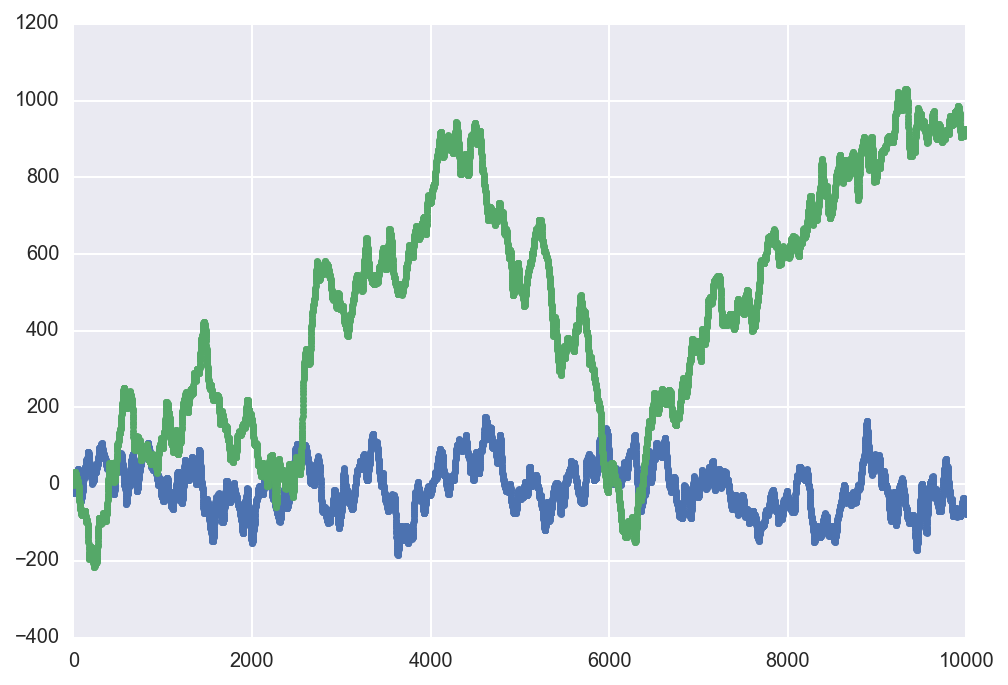

In [54]:
# Let's compare several AR-2 series :
np.random.seed(9)
serTest_A = rek_generateSeries_AR(10000,0.0,[0.9+0.99,-0.9*0.99])  # roots of characteristic polynom = [0.9,0.99] -> stationary
plt.plot(serTest_A,'.')
serTest_B = rek_generateSeries_AR(10000,0.0,[0.9+1.00,-0.9*1.00])  # one root is a unit root. -> random-walk type behavior
plt.plot(serTest_B,'.')
serTest_C = rek_generateSeries_AR(10000,0.0,[0.5+1.01,-0.5*1.01])  # one root has magnitude > 1. -> explosive behavior
#plt.plot(serTest_C,'.') # blows up rapidly , so remove it from the plot

In [55]:
# Let's look at an AR-2 series

In [56]:
np.random.seed(222)
(N,mu,phi) = (100000,0,[1.4,-0.45]) # roots of characteristicPoly are 0.5 and 0.9
ser_AR2 = rek_generateSeries_AR(N,mu,phi)

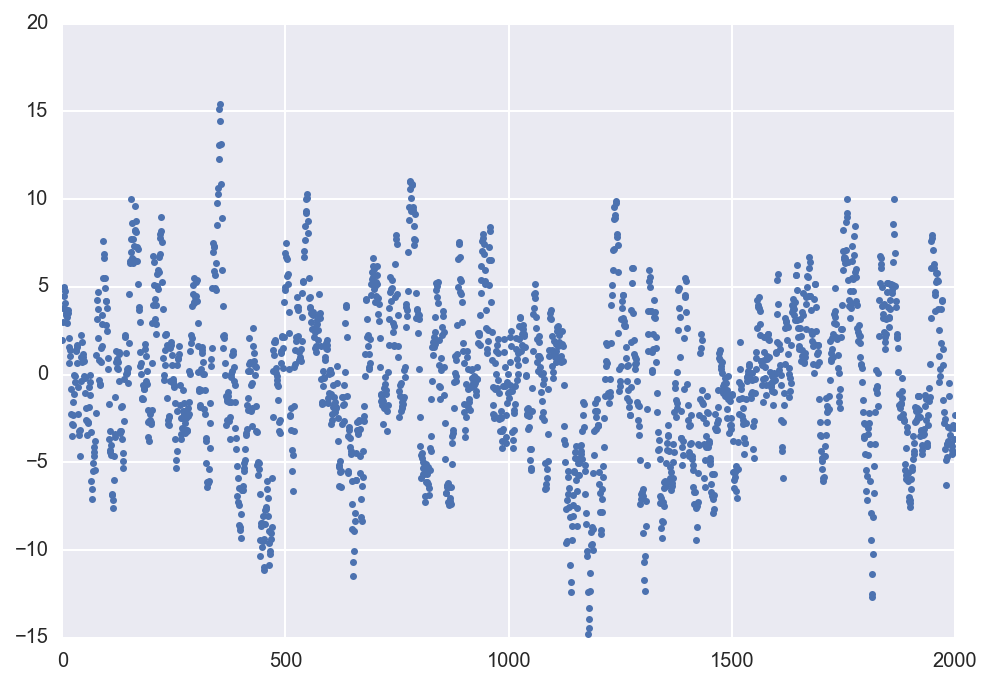

In [57]:
plt.plot(ser_AR2[:2000],'.')

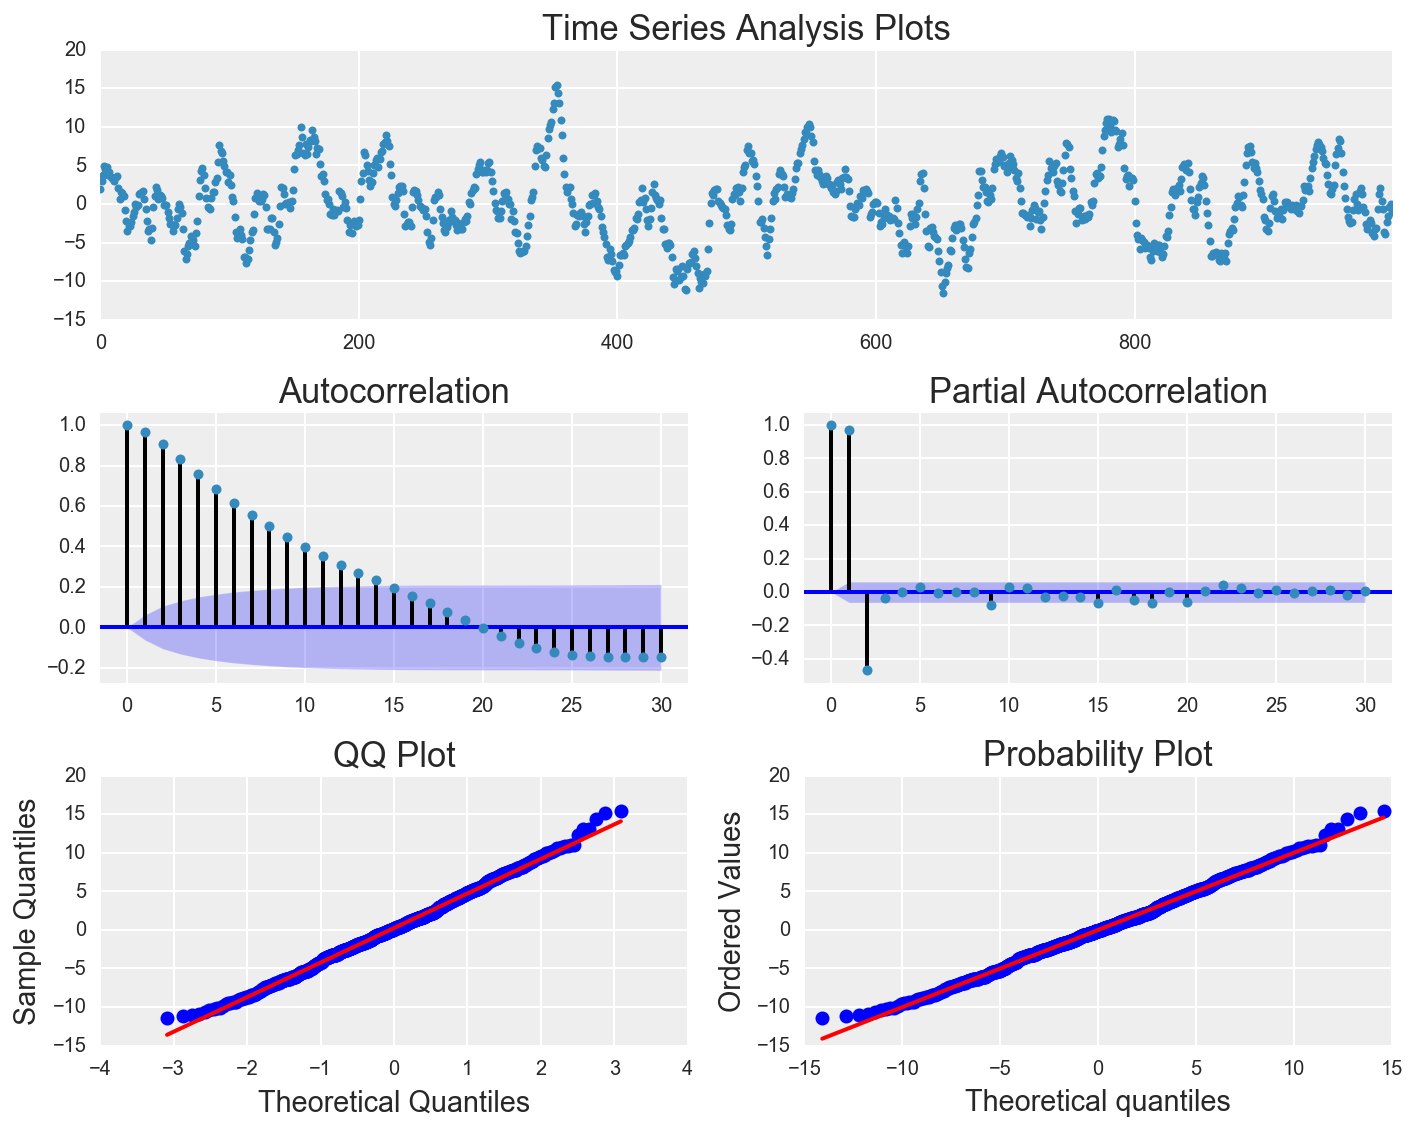

In [58]:
tsplot(ser_AR2[:1000],lags=30)
# PACF clearly suggests that a second-order AR model is a possible match for this time series

In [59]:
# Aside: numpy has some useful polynomial functions:
    # np.polynomial.polynomial.polyfromroots(myRoots) computes coeffs of a polynomial from its roots
    # np.roots(P) computes the roots from the polynomial coeffs
    # but for some reason, the input polynomial is high-to-low order for np.roots() 
                    # while the output polynomial is low-to-high order for polyfromroots()
        # so you have to flip the coeffs, or else you'll get the reciprocals of original roots
    

myRoots = [2,3,0]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots)
print(myPolynomial)
againRoots_rev = np.roots(myPolynomial)   # poly reversal => lower order, b/c one of the roots was a zero
print(againRoots_rev)
againRoots_forward = np.roots(myPolynomial[::-1])
print(againRoots_forward)

myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots)[::-1]
againRoots_v1 = np.roots(myPolynomial)
print(againRoots_v1)

# If you expect real coeffs, it can be helpful to force that explicitly to reduce computational errors:
myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
myPolynomial = np.polynomial.polynomial.polyfromroots(myRoots).real[::-1]
againRoots_v2 = np.roots(myPolynomial)
print(againRoots_v2)

[ 0.  6. -5.  1.]
[ 0.5         0.33333333]
[ 3.  2.  0.]
[ 0.40000000 +3.00000000e-01j  0.90000017 +1.62021090e-09j
  0.89999983 -1.62021453e-09j  0.80000000 +3.11709840e-15j
  0.40000000 -3.00000000e-01j]
[ 0.90000015+0.j   0.89999985+0.j   0.80000000+0.j   0.40000000+0.3j
  0.40000000-0.3j]


In [60]:
# Now let's look at an AR-5 series:

np.random.seed(555)
myRoots = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]  # make the poly terms real-valued by including conjug for any cplx number
phiVector = -1*(np.polynomial.polynomial.polyfromroots(myRoots)).real[:-1][::-1]
    # https://en.wikipedia.org/wiki/Autoregressive_model (condition for a "wide-sense" stationary model: abs(eachRoot)<1
    # https://www2.stat.duke.edu/~km68/materials/214.8%20(ARp).pdf   (author = Kai Mao?)
(N,mu,phi) = (100000,0,phiVector) 
ser_AR5 = rek_generateSeries_AR(N,mu,phi)

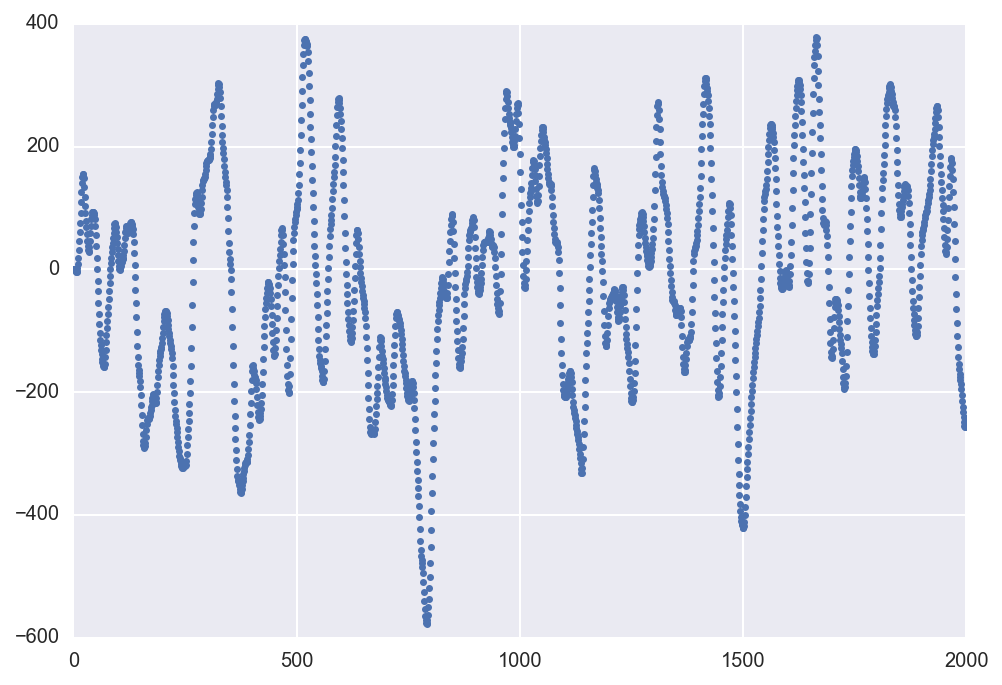

In [61]:
plt.plot(ser_AR5[:2000],'.')

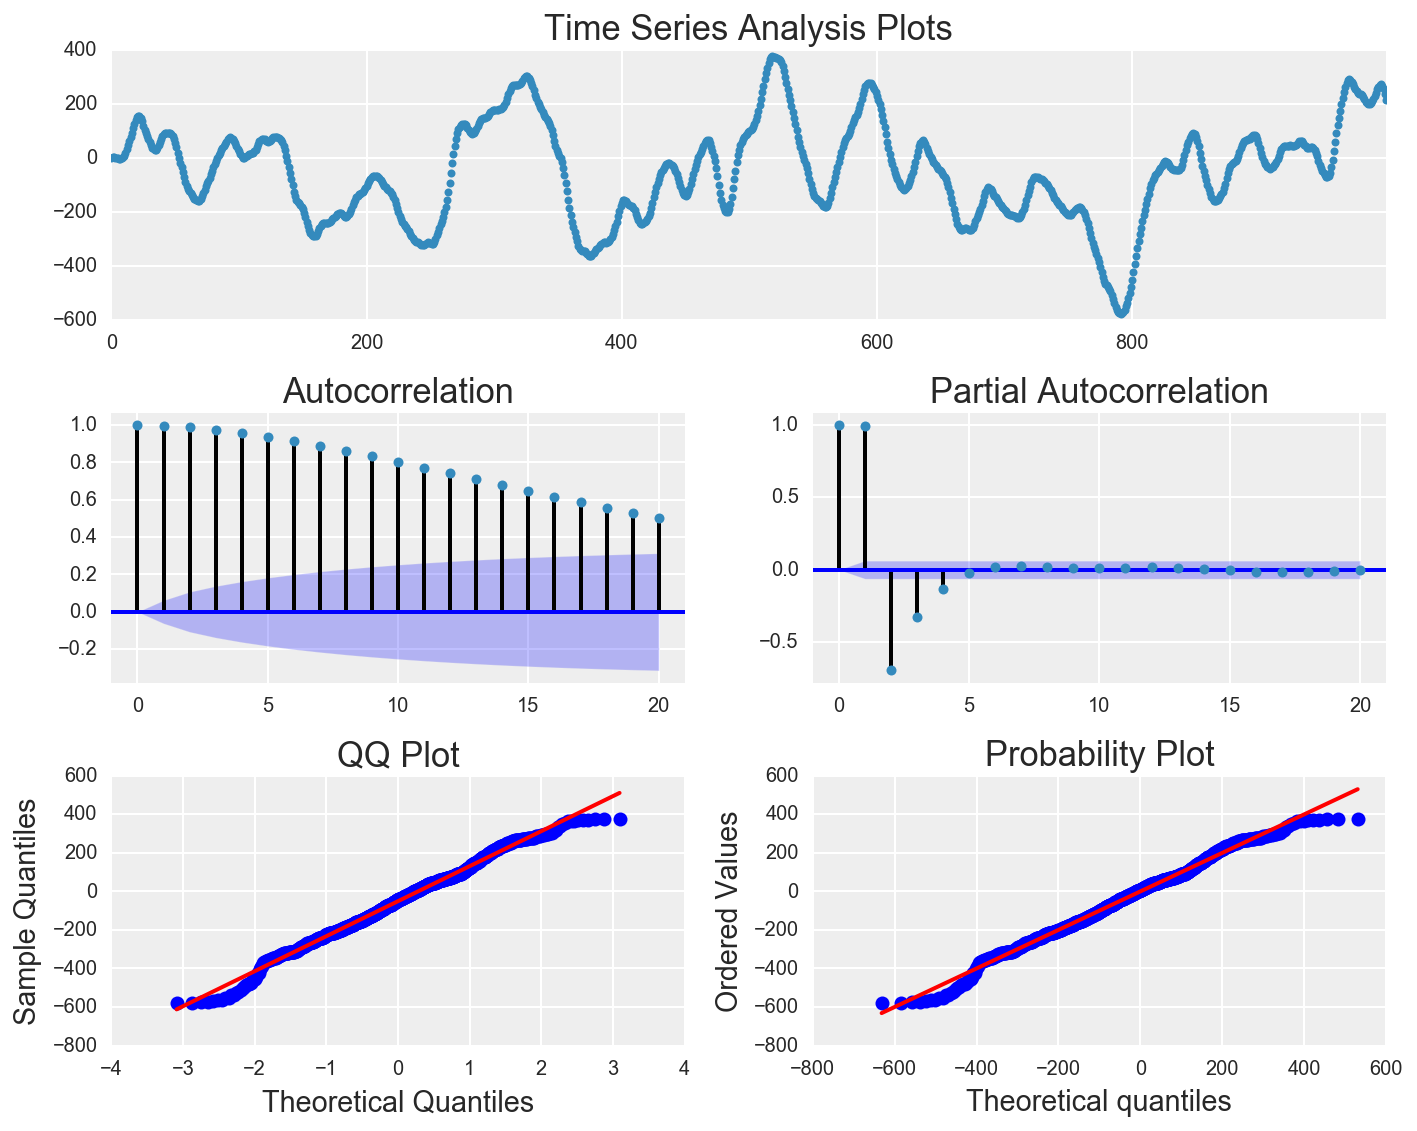

In [62]:
tsplot(ser_AR5[:1000],lags=20)

In [63]:
# PACF shows that an AR model is a good match.
# But it's difficult to identify exactly what order the series should be.
    # Note that the PACF at lag=5 is well inside the error bounds.
    

In [64]:
# Okay, now let's look at MA models.

def rek_generateSeries_MA(n,mu,theta):
    # n === number of points
    # mu === mean of series
    # theta === vector of MA coeffs (len(theta) = MA order).   Coeff on eps_0 is always one.
    epsilon=np.random.normal(size=n)
    thetaRev = theta[::-1]
    ser = np.zeros(n)
    ser[0] = mu + epsilon[0]
    for i in range(1,len(theta)):
        ser[i] = epsilon[i] + mu + np.dot(thetaRev[-i:],epsilon[:i])
    for i in range(len(theta),n):
        ser[i] = epsilon[i] + mu + np.dot(thetaRev,epsilon[(i-len(theta)):i])
    return ser

In [65]:
np.random.seed(1534)
ser_MA7 = rek_generateSeries_MA(100000,0,[1,1,1,1,1,1,1])
np.random.seed(1536)
ser_MA6 = rek_generateSeries_MA(100000,0,[1,1,1,1,1,1])

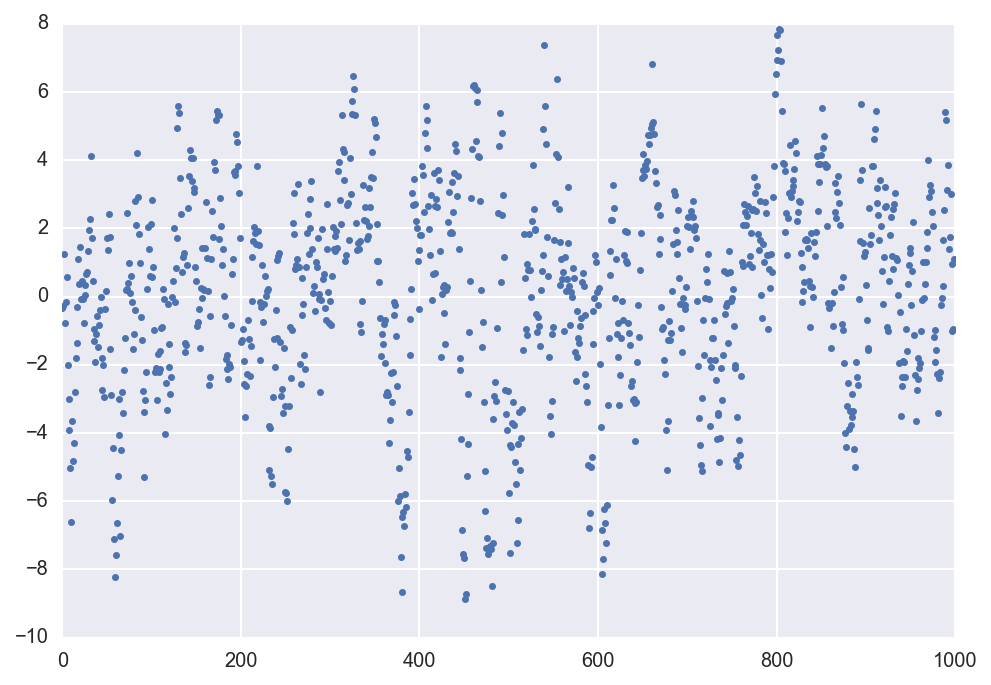

In [66]:
plt.plot(ser_MA7[:1000],'.')

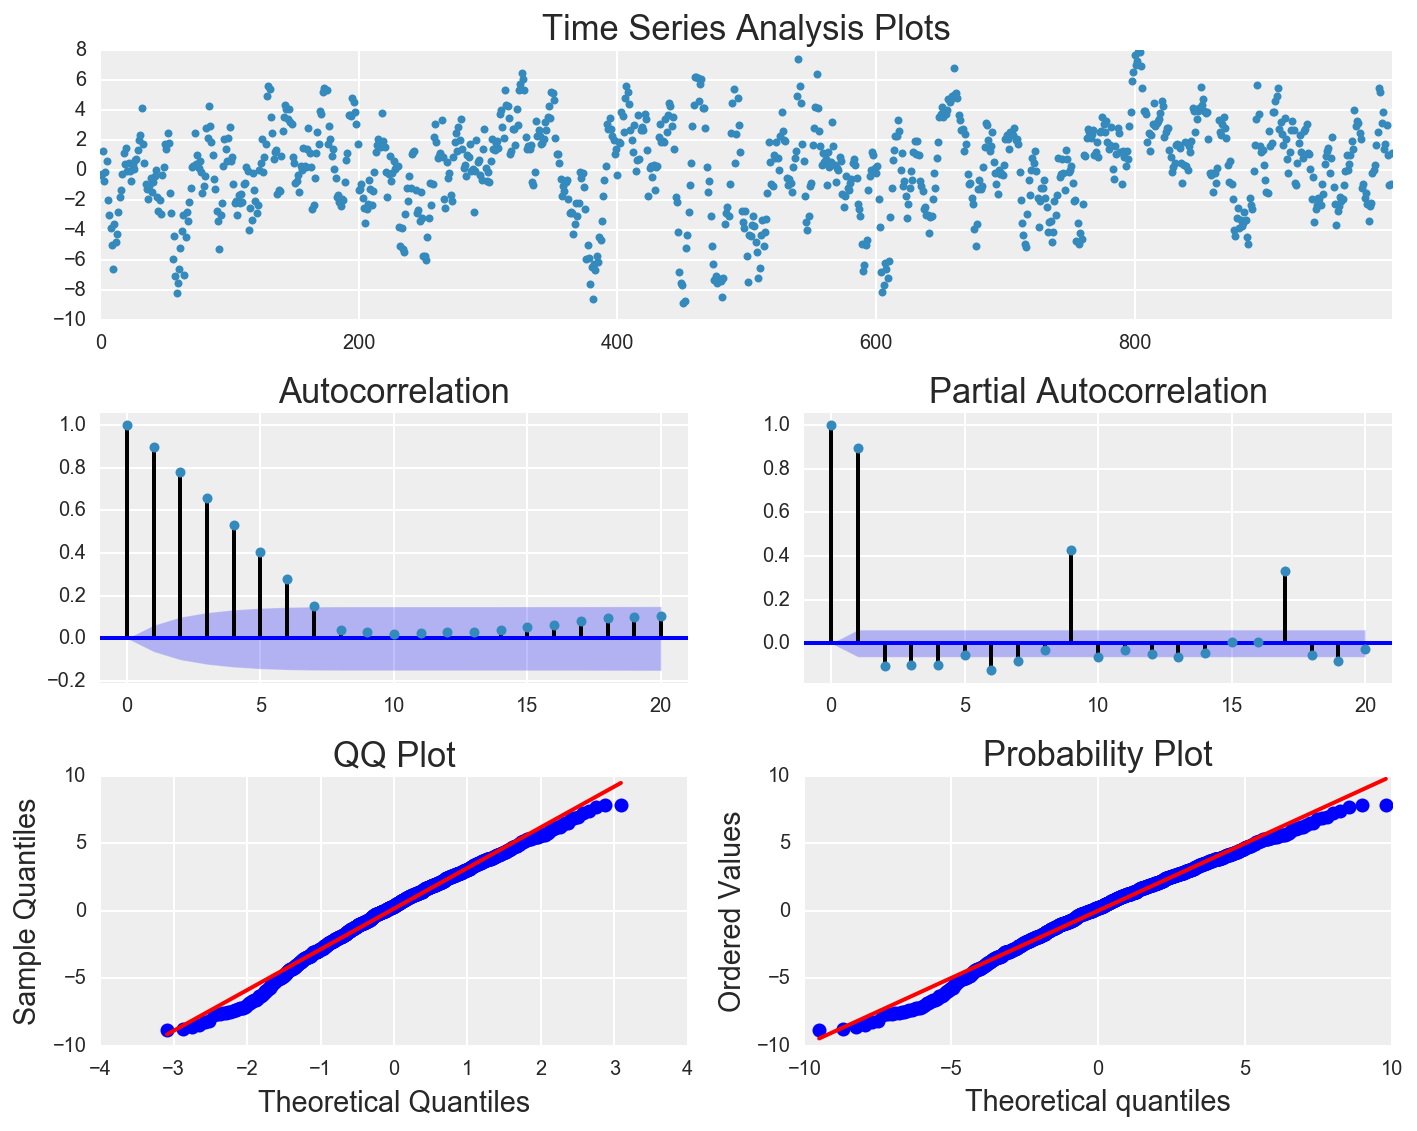

In [67]:
tsplot(ser_MA7[:1000],lags=20)

In [68]:
# To identify a MovingAverage model, the ACF is more useful than PACF.
# MA is a finite impulse-response series, so there should be zero correlation at lags >= the theta-vector length (7)
# In this case, the last statistically significant ACF lag is 7, as expected.
    # Note however that since AR coeffs drop steadily, it can be difficult to identify the length of a longer MA series 
    # Coeff Theta7 is just above the standard error
# PACF has large values at lags=[1,9,17]

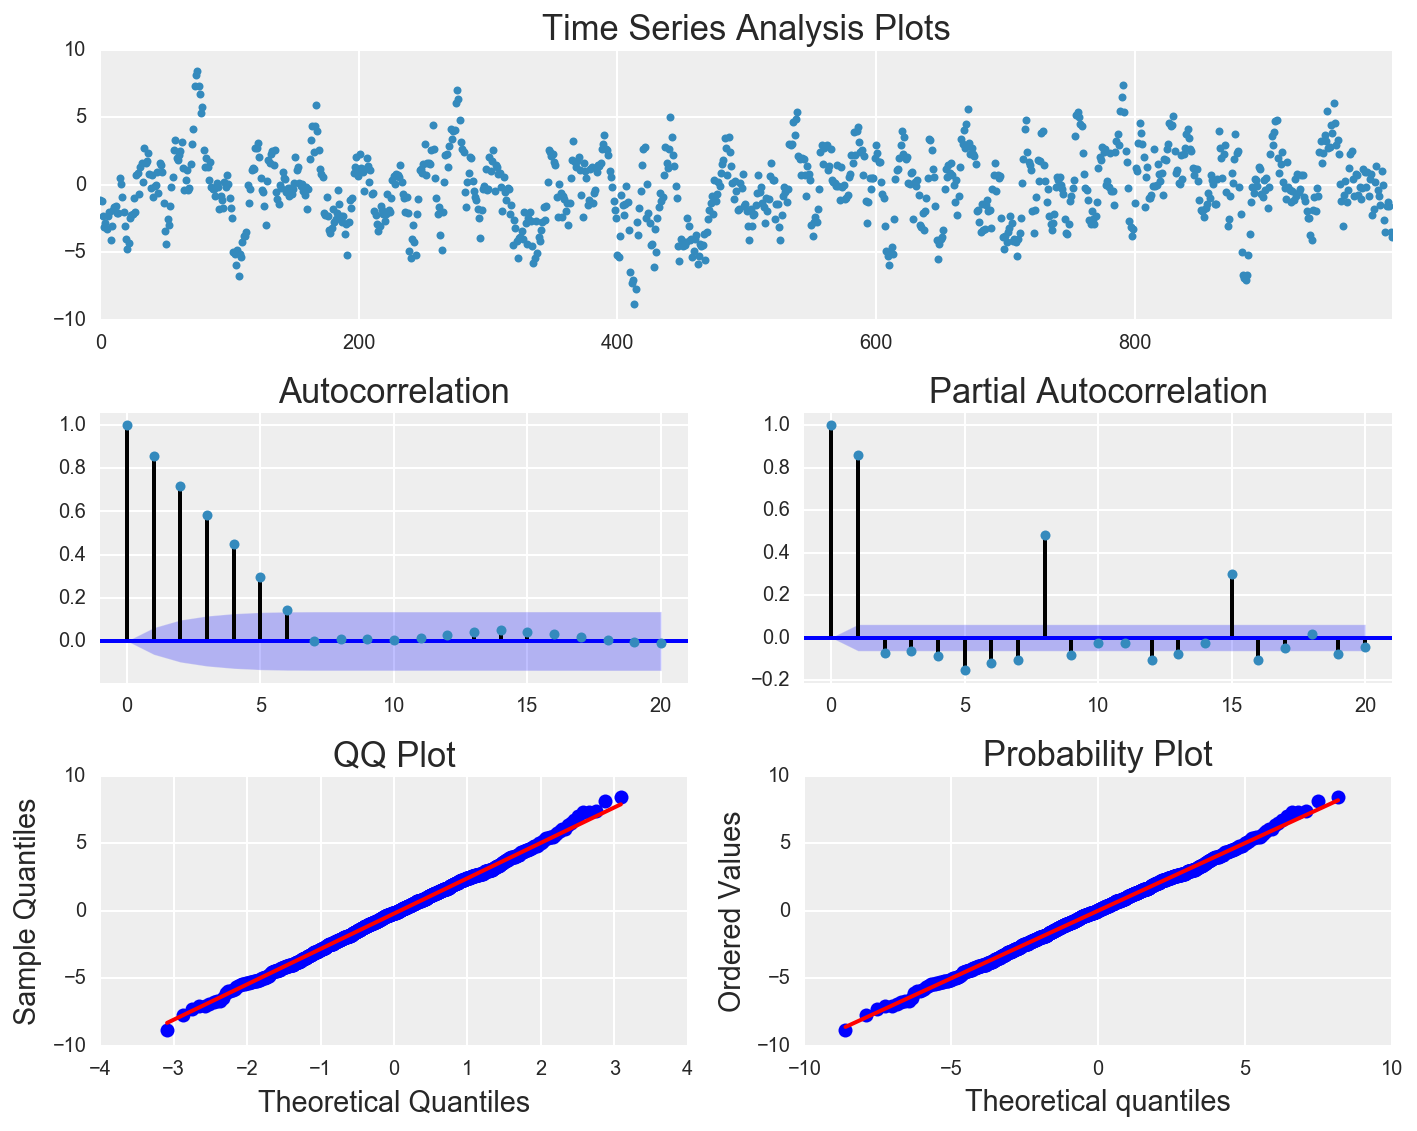

In [69]:
tsplot(ser_MA6[:1000],lags=20)

In [ ]:
# Same behavior in ACF and PACF (now large PACF at lags=[1,8,15])

In [ ]:
# Let's investigate our synthetic series using a standard ARIMA approach
    # Choose limits for p,d,q
        # Since we know that the series are zero-mean, we expect d=0 for all these series
    # Choose model decision criterion (AIC vs. BIC)
        # BIC will choose a more parsimonious model, AIC will prefer a model with slightly more training-set accuracy

In [73]:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR1 Returns

# pick best order and final model based on aic, bic

best_aic_serar1 = np.inf
best_bic_serar1 = np.inf
bestFit_aic_serar1 = None
bestFit_bic_serar1 = None

pq_rng = range(6) # [0,1,2,3,4,5,6,7,8]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serar1:
                    best_aic_serar1 = tmp_aic
                    bestFit_aic_serar1 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serar1:
                    best_bic_serar1 = tmp_bic
                    bestFit_bic_serar1 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serar1, bestFit_aic_serar1[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serar1, bestFit_bic_serar1[0]))


# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

(0, 0, 1, 420461.8380447159, 420480.86389564589)
(0, 0, 2, 368488.6188547933, 368517.15763118822)
(0, 0, 3, 340148.0729179297, 340186.12461978954)
(0, 0, 4, 323600.7645089916, 323648.32913631649)
(0, 0, 5, 312873.09932068543, 312930.17687347525)
(1, 0, 0, 283732.1760070005, 283751.20185793046)
(1, 0, 1, 283734.10341126996, 283762.64218766487)
(1, 0, 2, 283735.5611085722, 283773.61281043204)
(1, 0, 3, 283737.53283682466, 283785.09746414953)
(1, 0, 4, 283739.31233370356, 283796.38988649339)
(1, 0, 5, 283741.19730550086, 283807.78778375563)
(2, 0, 0, 283734.1030550388, 283762.64183143369)
(2, 0, 1, 283735.8209090913, 283773.87261095113)
(2, 0, 2, 283737.5078619154, 283785.07248924026)
(2, 0, 3, 283739.5064960562, 283796.58404884604)
(2, 0, 4, 283741.29732608824, 283807.88780434302)
(2, 0, 5, 283742.6066559032, 283818.710059623)
(3, 0, 0, 283735.5590487219, 283773.61075058178)
(3, 0, 1, 283737.5081404679, 283785.07276779279)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 2, 283738.34559257317, 283795.42314536299)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 3, 283737.22052698064, 283803.81100523542)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 4, 283740.990809767, 283817.09421348677)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 5, 283739.3946063531, 283825.01093553781)
(4, 0, 0, 283737.53179028095, 283785.09641760582)
(4, 0, 1, 283739.50697766145, 283796.58453045128)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 2, 283737.11255103734, 283803.70302929211)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 3, 283736.6245253428, 283812.72792906256)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 4, 283738.2766606805, 283823.89298986521)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 5, 283739.6791578202, 283834.80841246987)
(5, 0, 0, 283739.3191500474, 283796.3967028372)
(5, 0, 1, 283741.30412252306, 283807.89460077783)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 2, 283740.725856211, 283816.82925993076)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 3, 283736.83067306905, 283822.44700225379)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 4, 283740.4305116155, 283835.55976626516)
(5, 0, 5, 283741.63582567975, 283846.27800579445)
aic: 283732.17601 | order: (1, 0, 0)
bic: 283751.20186 | order: (1, 0, 0)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


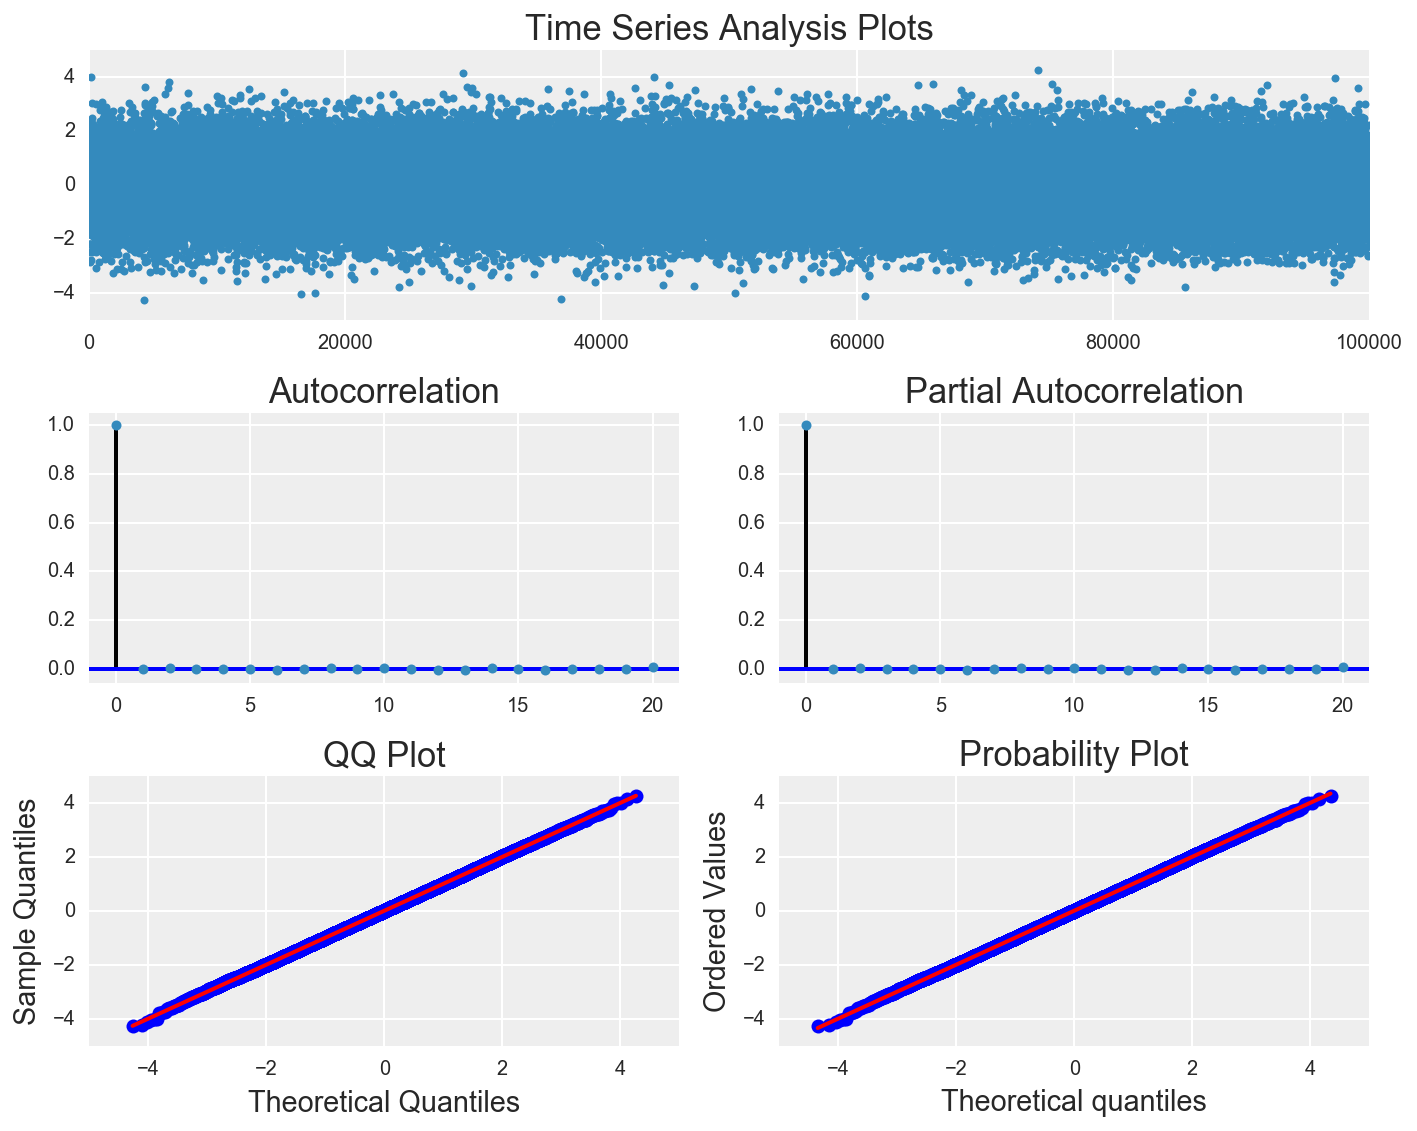

In [75]:
best_mdl = bestFit_aic_serar1[1]
# ARIMA model resid plot
tsplot(best_mdl.resid, lags=20)

In [93]:
# Looks great. There is no correlation between the residuals after fitting ARIMA(1,0,0)

In [94]:
# But that took 20 minutes, so let's reduce N when looking at our other synthetic time series.
    # Just the first 10k points in the others, but we'll increase test (p,q) max to 8

In [77]:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serar5 = np.inf
best_bic_serar5 = np.inf
bestFit_aic_serar5 = None
bestFit_bic_serar5 = None

pq_rng = range(9) # [0,1,2,3,4,5,6,7,8]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serar5:
                    best_aic_serar5 = tmp_aic
                    bestFit_aic_serar5 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serar5:
                    best_bic_serar5 = tmp_bic
                    bestFit_bic_serar5 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serar5, bestFit_aic_serar5[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serar5, bestFit_bic_serar5[0]))

(0, 0, 1, 118640.27862638017, 118654.69930712412)
(1, 0, 0, 79625.19432466109, 79639.615005405038)
(2, 0, 4, 28974.63389098462, 29025.106273588452)
(2, 0, 5, 28703.71560994194, 28761.39833291775)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 6, 28623.161796349646, 28688.054859697433)
(2, 0, 7, 28597.39236116905, 28669.495764888812)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 8, 28582.418884223127, 28661.732628314865)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 1, 29133.902379386283, 29169.954081246164)
(3, 0, 2, 28654.992518144387, 28698.254560376245)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 3, 28573.02154280083, 28623.493925404662)
(3, 0, 4, 28570.019725573635, 28627.702448549444)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 5, 28571.21131558874, 28636.104378936525)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 6, 28572.524495501923, 28644.627899221683)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 7, 28574.29462662143, 28653.608370713169)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 8, 28576.358245835105, 28662.88233029882)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 1, 28582.04949590882, 28625.311538140679)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 2, 28572.95587251042, 28623.428255114253)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 3, 28569.76055234646, 28627.443275322268)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 4, 28571.45973800658, 28636.352801354366)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 5, 28573.85313985282, 28645.956543572582)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 6, 28574.289451146262, 28653.603195238)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 7, 28575.73440329668, 28662.258487760395)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 8, 28578.86079324483, 28672.595218080518)
(5, 0, 1, 28568.214603913362, 28618.686986517194)
(5, 0, 2, 28569.7312599591, 28627.413982934908)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 3, 28571.235349525003, 28636.128412872789)
(5, 0, 4, 28572.28103641025, 28644.384440130012)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 5, 28574.5774830927, 28653.891227184438)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 6, 28579.279031107566, 28665.803115571282)
(5, 0, 7, 28591.384825379697, 28685.119250215386)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 1, 28569.45527661981, 28627.137999595619)
(6, 0, 2, 28570.992002692547, 28635.885066040333)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 3, 28573.240760436143, 28645.344164155904)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 4, 28577.10214958406, 28656.415893675799)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 5, 28577.320800391477, 28663.844884855193)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 6, 28589.943980736047, 28683.678405571736)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 7, 28592.483349976792, 28693.428115184459)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 1, 28570.960318399382, 28635.853381747169)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 2, 28572.43911109097, 28644.542514810732)
(7, 0, 3, 28574.292242147705, 28653.605986239443)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 4, 28576.480219671415, 28663.004304135131)
(7, 0, 5, 28578.091270753845, 28671.825695589534)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 6, 28580.813057721625, 28681.757822929292)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 7, 28582.02752200321, 28690.182627582853)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 8, 28583.413177565802, 28698.778623517421)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 1, 28573.931542106682, 28646.034945826443)
(8, 0, 2, 28574.244891427043, 28653.558635518781)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 3, 28576.5923842377, 28663.116468701417)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 4, 28578.469290165747, 28672.203715001437)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 5, 28580.499453829718, 28681.444219037385)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 6, 28583.747431375712, 28691.902536955356)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 7, 28583.858736459973, 28699.224182411592)
(8, 0, 8, 28585.496973898495, 28708.07276022209)
aic: 28568.21460 | order: (5, 0, 1)
bic: 28618.68699 | order: (5, 0, 1)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# A lot of times, the ARIMA model fails to converge. Here it failed on (5,0,0)
        # (which was actually the true underlying model ...)

In [185]:
# Let's look at the chosen (5,0,1) model. Does it minimize residuals? Perhaps the MA1 coefficient is near zero?
mdl_501_serar5 = smt.ARIMA(ser_AR5[:10000], order=(5,0,1)).fit(method='mle', trend='nc')
print((mdl_501_serar5.aic,mdl_501_serar5.bic))
print((mdl_501_serar5.arparams,mdl_501_serar5.maparams))

(28568.214603913362, 28618.686986517194)
(array([ 3.38872807, -4.54224637,  3.04944239, -1.05136762,  0.15461873]), array([ 0.01183861]))


In [187]:
# Recall that our underlying AR model had params
roots_serar5 = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]  # make the poly terms real-valued by including conjug for any cplx number
phiVector_serar5 = -1*(np.polynomial.polynomial.polyfromroots(roots_serar5)).real[:-1][::-1]
print(phiVector_serar5)

[ 3.4    -4.58    3.098  -1.0809  0.162 ]


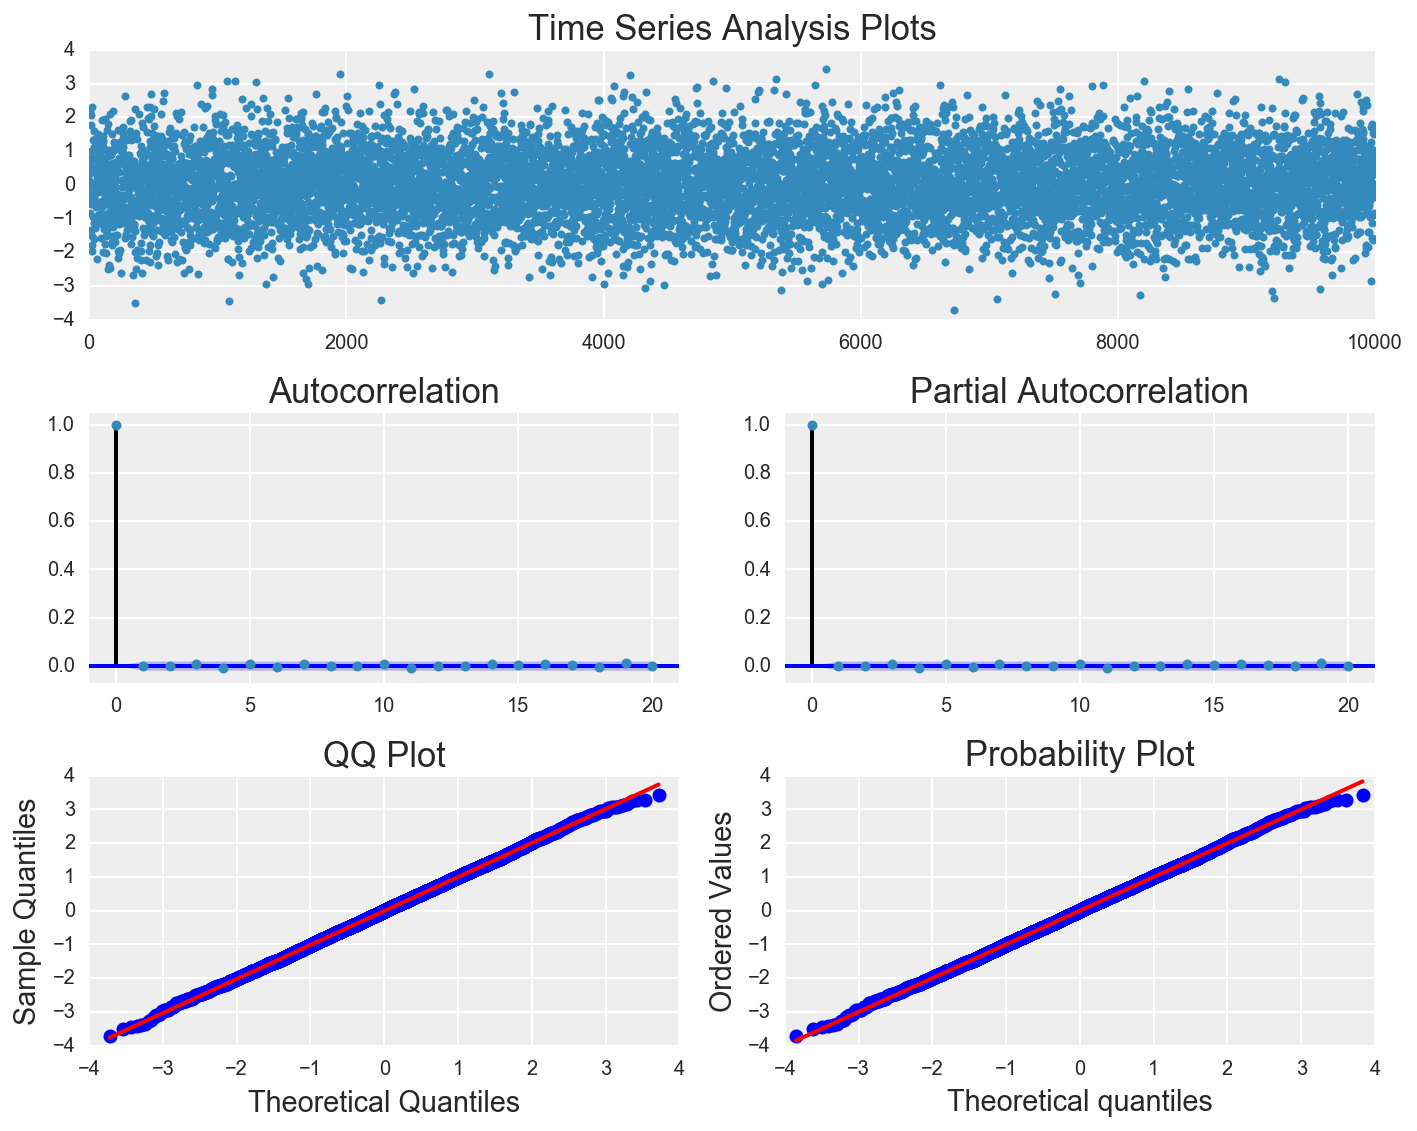

In [189]:
# decent match to underlying phiVector. Also the MA1 coeff is small.
# So our ARIMA(5,0,1) model is probably a decent fit
# What do the residuals look like?
tsplot(mdl_501_serar5.resid, lags=20)

In [190]:
# Looks good. No signs of residual autocorrelation or heteroscedasticity.
rek_LjungBox(mdl_501_serar5.resid, lags=20)

(array([  7.21001207e-05,   1.85386015e-02,   2.53753145e-01,
          9.65292260e-01,   1.27588323e+00,   1.48731985e+00,
          1.88737324e+00,   1.93891804e+00,   1.97412978e+00,
          2.44388464e+00,   3.21322561e+00,   3.26894803e+00,
          3.27209701e+00,   3.81444834e+00,   3.99601436e+00,
          4.49093928e+00,   4.51957684e+00,   4.65983413e+00,
          5.65990225e+00,   5.68185765e+00]),
 array([ 0.9932251 ,  0.99077353,  0.96847788,  0.91501235,  0.9373936 ,
         0.9603324 ,  0.96581003,  0.98282752,  0.99187013,  0.99166846,
         0.98759712,  0.99332893,  0.99676135,  0.99648271,  0.99775036,
         0.99776044,  0.99883607,  0.99929797,  0.99861837,  0.99926399]))

In [ ]:
# P-Values are really high (meaning this series is even less correlated than would be expected for white noise)
    # This probably means nothing.

In [78]:
# Okay the ARIMA(5,0,1) series produced a pretty good fit.
# But what about ARIMA(5,0,0)? Why didn't that model find a fit?

tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc')

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [90]:
# Interesting that this ser_AR5 dataset always fails to fit AR(p) models (where p>=2), but generally works whenever q>=1
    # q!=0 runs through a different branch in statsmodels (class ARMA, method _fit_start_params_hr)
        # so perhaps it does different checks on the initial fit.

# For some reason statsmodels' initial estimates for our AR params suggest a non-stationary series.
        # (Even though we know that the true underlying params are in fact stationary)

In [132]:
np.roots([1,-0.1,-0.2])

array([ 0.5, -0.4])

In [91]:
# Try to see if we can find usable initial params for the simplest AR model that failed above:
        # i.e. try to find a starting point with an AR(2) model, to understand the initial stationarity test:
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[0.1,0.2])
    # This one fails even after starting with a model known to be stationary (roots of x^2-0.1x-0.2 are [0.5,-0.4])

LinAlgError: SVD did not converge

In [ ]:
# Trying lots of parameters,
    # one can avoid the "computed initial AR coefficients are not stationary" error easily enough
    # but it is very common to encounter "LinAlgError: SVD did not converge"

In [92]:
# It does manage to execute for this start condition, although giving a warning:
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[0.1,0.3])

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [124]:
# Let's go back to our AR2-series with roots 0.5 and 0.9
# It finds good params even for starting points pretty close to a unit root
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[1.39999,-0.4])

In [125]:
tmp_mdl.arparams

array([ 1.41184858, -0.46199017])

In [126]:
# It is possible to get TOO close though, so that the SVD doesn't converge:
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[1.399999,-0.4])

LinAlgError: SVD did not converge

In [130]:
# It can find an optimal fit even the starting params are way off (as if roots are [-0.4,+0.1]):
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[-0.3,0.4])

In [128]:
tmp_mdl.arparams

array([ 1.41184857, -0.46199014])

In [131]:
# But you can get convergence errors even when init conds are clearly feasible (as if roots are [-0.5,+0.1]):
tmp_mdl = smt.ARIMA(ser_AR2[:10000], order=(2,0,0)).fit(method='mle', trend='nc', start_params=[-0.4,0.5])

LinAlgError: SVD did not converge

In [150]:
# Return to the ser_AR5 dataset, with start_params equal to the underlying generative model:
roots_serAR5model = [0.9,0.9,0.8,0.4+0.3j,0.4-0.3j]
phiVector_serar5 = -1*(np.polynomial.polynomial.polyfromroots(roots_serAR5model)).real[:-1][::-1]
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc', start_params=phiVector_serar5)

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [161]:
# Didn't give an error this time, but MLE optimization failed to converge
print(tmp_mdl.arparams)
print(phiVector_serar5)
# Didn't move very far either (this is good, b/c phiVector is the underlying generative model anyway)
print((tmp_mdl.aic,best_aic))
print((tmp_mdl.bic,best_bic))
# This (5,0,0) model beats out our previous (5,0,1) fit using BIC, but not quite using AIC.

[ 3.40034283 -4.5789907   3.09343201 -1.07588082  0.16020356]
[ 0.7      0.06     0.078   -0.0965   0.00875]
(28568.96480046764, 28568.214603913362)
(28612.226842699496, 28618.686986517194)


In [162]:
# We get SVD convergence issues when we choose a starting point that is further away:
roots_Test = [0.7,0.5,0.1,-0.3-0.4j,-0.3+0.4j]
phiVector = -1*(np.polynomial.polynomial.polyfromroots(roots_Test)).real[:-1][::-1]
tmp_mdl = smt.ARIMA(ser_AR5[:10000], order=(5,0,0)).fit(method='mle', trend='nc', start_params=phiVector)

LinAlgError: SVD did not converge

In [200]:
# Let's see what happens for ser_MA7:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serma7 = np.inf
best_bic_serma7 = np.inf
bestFit_aic_serma7 = None
bestFit_bic_serma7 = None

pq_rng = range(10) # [0,1,2,3,4,5,6,7,8,9]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA7[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serma7:
                    best_aic_serma7 = tmp_aic
                    bestFit_aic_serma7 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serma7:
                    best_bic_serma7 = tmp_bic
                    bestFit_bic_serma7 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serma7, bestFit_aic_serma7[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serma7, bestFit_bic_serma7[0]))

(0, 0, 1, 41305.460506615105, 41319.88118735906)
(0, 0, 2, 37900.84922107298, 37922.480242188911)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 0, 3, 35252.804845612816, 35281.646207100719)
(0, 0, 4, 35253.992708355545, 35290.044410215429)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 0, 5, 35229.20169447365, 35272.463736705511)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 0, 6, 35229.5159438385, 35279.988326442333)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 0, 7, 28472.98659304937, 28530.669316025178)
(1, 0, 0, 34787.30485563511, 34801.725536379068)
(1, 0, 1, 34760.844967114215, 34782.475988230144)
(1, 0, 2, 34709.39587561157, 34738.237237099471)
(1, 0, 3, 34688.81520475906, 34724.866906618947)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 4, 34128.71602143661, 34171.978063668466)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 5, 33689.99003116696, 33740.462413770794)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 6, 32497.168570162703, 32554.851293138512)
(1, 0, 7, 28474.916189949636, 28539.809253297422)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 8, 28476.924869838444, 28549.028273558204)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 9, 28481.610372568524, 28560.924116660262)
(2, 0, 0, 34755.6018566448, 34777.232877760725)
(2, 0, 1, 34578.64947841281, 34607.490839900711)
(2, 0, 2, 34547.46975822888, 34583.521460088763)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 4, 33939.194359839195, 33989.666742443027)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 5, 32437.25854359458, 32494.941266570389)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 6, 31349.803400629717, 31414.696463977503)
(2, 0, 7, 28476.770239001107, 28548.873642720868)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 8, 28480.033005730478, 28559.346749822216)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 9, 28481.64952833887, 28568.173612802584)
(3, 0, 0, 34689.29338082816, 34718.134742316062)
(3, 0, 1, 34551.595091139374, 34587.646792999258)
(3, 0, 2, 34090.09540327119, 34133.357445503047)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 4, 33513.89091672627, 33571.573639702081)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 5, 32466.10705446342, 32531.000117811207)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 6, 30953.036016868955, 31025.139420588715)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 7, 28478.69265528814, 28558.006399379879)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 8, 28481.696124810507, 28568.220209274223)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 9, 28484.635628757558, 28578.370053593248)
(4, 0, 0, 34647.111166521594, 34683.162868381478)
(4, 0, 1, 34540.95696147266, 34584.219003704515)
(4, 0, 2, 33786.47314555383, 33836.945528157659)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 3, 33371.05666100318, 33428.739383978995)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 4, 33066.055255401676, 33130.948318749462)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 5, 32154.090314502493, 32226.193718222254)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 6, 31372.027074530986, 31451.340818622724)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 7, 28479.732670861606, 28566.256755325321)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 8, 28486.050301377105, 28579.784726212794)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 9, 28485.92923945958, 28586.874004667246)
(5, 0, 0, 34601.39192609703, 34644.653968328887)
(5, 0, 1, 34511.2979963385, 34561.770378942332)
(5, 0, 2, 33845.97290810922, 33903.655631085036)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 3, 33329.215869518725, 33394.108932866511)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 4, 31751.599136525758, 31823.702540245518)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 5, 31625.01641016054, 31704.330154252279)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 6, 30087.795545083998, 30174.319629547714)
(5, 0, 7, 28480.913776668738, 28574.648201504428)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 8, 28488.908171658615, 28589.852936866282)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 9, 28487.476026314827, 28595.631131894472)
(6, 0, 0, 34500.44130279266, 34550.913685396488)
(6, 0, 1, 34446.458530209915, 34504.141253185728)
(6, 0, 2, 33552.46347580245, 33617.356539150234)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 3, 32039.164412130616, 32111.267815850377)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 4, 32000.999945648, 32080.313689739738)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 5, 31121.367952358683, 31207.892036822399)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 6, 29909.752654703043, 30003.487079538732)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 7, 28482.80830735993, 28583.753072567597)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 8, 28488.196803507406, 28596.35190908705)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 9, 28490.248074246258, 28605.613520197876)
(7, 0, 0, 34406.79813288325, 34464.480855859059)
(7, 0, 1, 34389.01807927848, 34453.911142626268)
(7, 0, 2, 32668.113405946166, 32740.216809665926)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 3, 31966.44505554841, 32045.758799640149)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 4, 31551.869565136694, 31638.39364960041)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 5, 30570.556834036095, 30664.291258871785)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 6, 29779.02965653477, 29879.974421742438)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 7, 28482.746678675943, 28590.901784255588)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 8, 28492.294427190096, 28607.659873141714)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 9, 28492.453441271336, 28615.029227594932)
(8, 0, 0, 34221.47469456804, 34286.367757915825)
(8, 0, 1, 33204.39383828011, 33276.497241999874)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 2, 32303.377408496246, 32382.691152587984)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 3, 31412.916168182426, 31499.440252646142)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 4, 31306.081740148777, 31399.816164984466)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 5, 30297.249183791886, 30398.193948999553)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 6, 30768.380835978005, 30876.535941557649)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 7, 28483.478893978303, 28598.844339929921)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 8, 28491.186011033813, 28613.761797357409)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 9, 28490.311336002378, 28620.097462697948)
(9, 0, 0, 32096.713609296028, 32168.817013015789)
(9, 0, 1, 32072.865425090786, 32152.179169182524)
(9, 0, 2, 32057.569078491677, 32144.093162955392)
(9, 0, 3, 32045.99896256303, 32139.733387398719)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 4, 30687.765038521757, 30788.709803729424)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 5, 30536.46759048832, 30644.622696067963)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 6, 29713.14572837652, 29828.511174328138)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 7, 28485.48603879858, 28608.061825122175)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 8, 28489.673527281902, 28619.459653977472)
(9, 0, 9, 28498.69492261498, 28635.691389682528)
aic: 28472.98659 | order: (0, 0, 7)
bic: 28530.66932 | order: (0, 0, 7)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


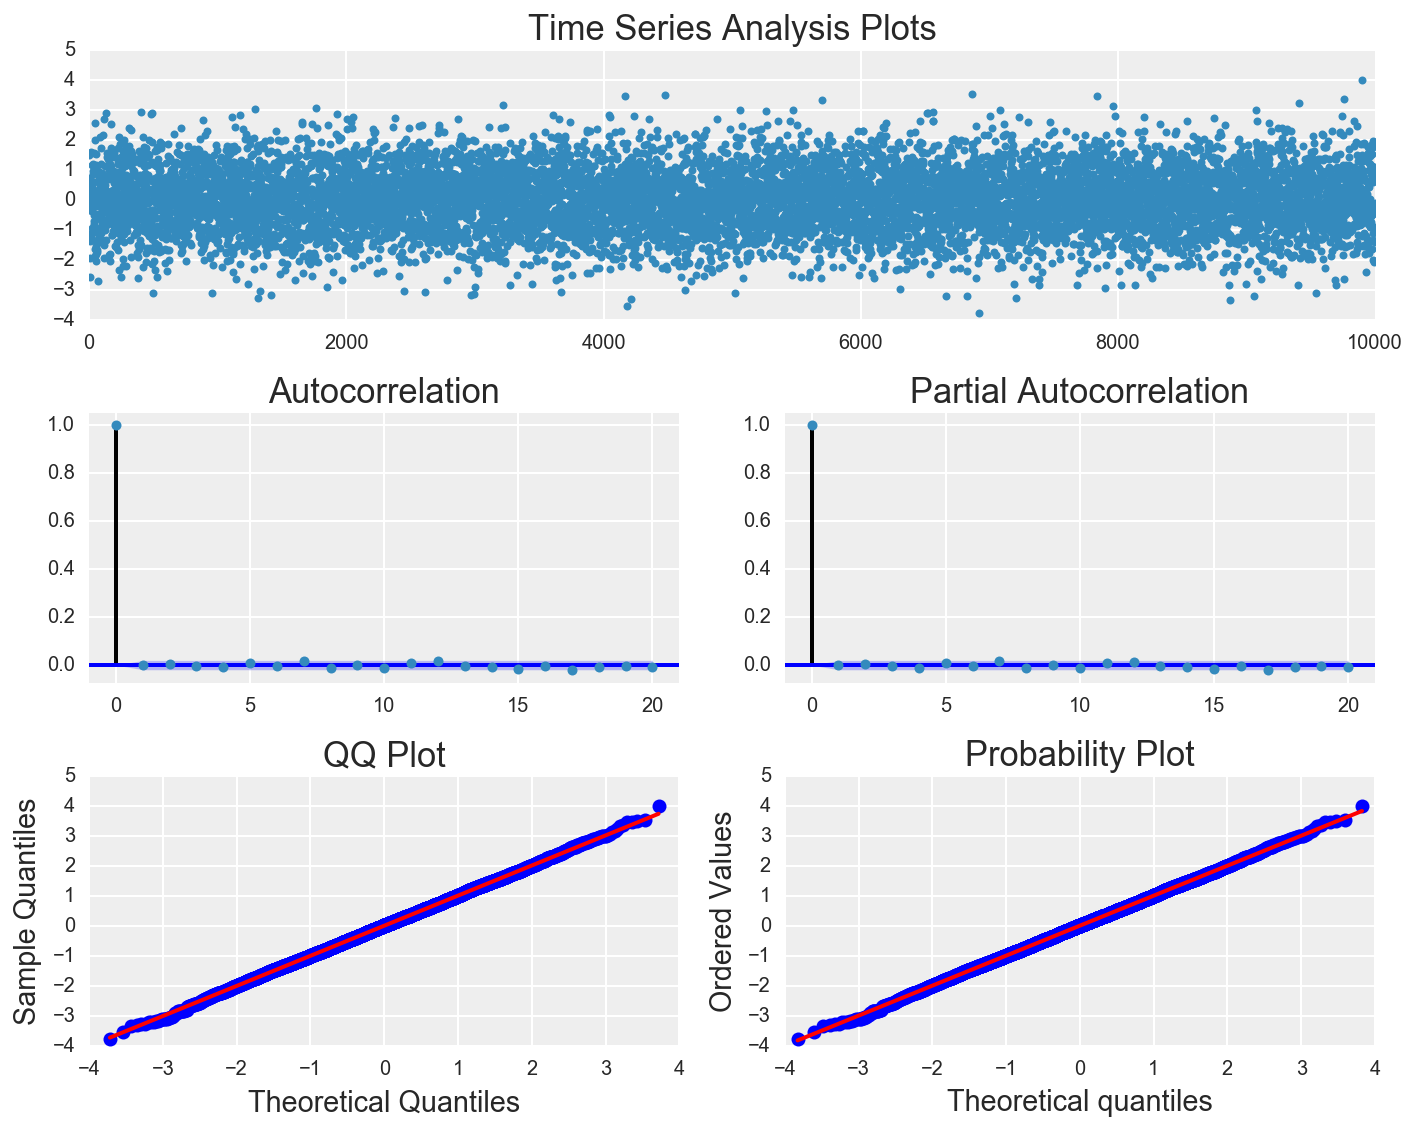

In [201]:
# MA(7) model was chosen by both AIC and BIC.

# Are the residuals well behaved?
tsplot(bestFit_aic_serma7[1].resid, lags=20)

In [202]:
rek_LjungBox(bestFit_aic_serma7[1].resid, lags=20)

(array([  0.02333957,   0.23498586,   0.30030625,   1.29830637,
          2.0716758 ,   2.17051163,   4.60339929,   5.6493161 ,
          5.65292071,   6.73157776,   7.32546626,   9.60549953,
          9.79040129,  10.21864641,  13.24262388,  13.55350311,
         18.39110625,  19.23401744,  19.29447953,  20.03283507]),
 array([ 0.87857735,  0.8891468 ,  0.95997087,  0.86166282,  0.83914109,
         0.90336755,  0.70823314,  0.6864468 ,  0.77408978,  0.75051933,
         0.77214742,  0.65052589,  0.71097759,  0.74602956,  0.58356392,
         0.6319384 ,  0.36457871,  0.37754781,  0.43809663,  0.45587741]))

In [ ]:
# The Residuals of ser_MA7, after fit by MA(7) model, appear to be white noise.

In [203]:
print((bestFit_aic_serma7[1].arparams,bestFit_aic_serma7[1].maparams))
# estimated Theta vector is very close to the underlying generator Theta (which is all ones)

(array([], dtype=float64), array([ 0.99998614,  0.9996067 ,  0.99981398,  0.99969288,  0.99941754,
        0.99977984,  0.9998566 ]))


In [204]:
# How about ser_MA6:
# RT: ~20min

# Fit ARIMA(p, d, q) model to ser_AR5 Returns
# pick best order and final model based on aic, bic

best_aic_serma6 = np.inf
best_bic_serma6 = np.inf
bestFit_aic_serma6 = None
bestFit_bic_serma6 = None

pq_rng = range(10) # [0,1,2,3,4,5,6,7,8,9]
d_rng = range(1) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA6[:10000], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_aic,tmp_bic))
                if tmp_aic < best_aic_serma6:
                    best_aic_serma6 = tmp_aic
                    bestFit_aic_serma6 = ((i,d,j),tmp_mdl)
                if tmp_bic < best_bic_serma6:
                    best_bic_serma6 = tmp_bic
                    bestFit_bic_serma6 = ((i,d,j),tmp_mdl)
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_serma6, bestFit_aic_serma6[0]))
print('bic: {:6.5f} | order: {}'.format(best_bic_serma6, bestFit_bic_serma6[0]))

(0, 0, 1, 40483.98416268657, 40498.404843430522)
(0, 0, 2, 37545.573261571255, 37567.204282687184)
(0, 0, 3, 35224.375201403855, 35253.216562891757)
(0, 0, 4, 35226.001237658624, 35262.052939518508)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 0, 5, 35195.848648563355, 35239.110690795213)
(0, 0, 7, 28360.50057056052, 28418.183293536331)
(1, 0, 0, 34548.933464366586, 34563.354145110541)
(1, 0, 1, 34505.01571370563, 34526.646734821559)
(1, 0, 2, 34460.69240736662, 34489.533768854526)
(1, 0, 3, 34436.92633756334, 34472.978039423222)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 4, 33612.97883021149, 33656.240872443348)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 5, 32617.07539043983, 32667.547773043661)
(1, 0, 6, 28360.49710261736, 28418.179825593168)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 7, 28356.168897164862, 28421.061960512649)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 8, 28357.890588797025, 28429.993992516786)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 0, 9, 28360.336420883188, 28439.650164974926)
(2, 0, 0, 34496.57042705679, 34518.201448172716)
(2, 0, 1, 34300.69875671364, 34329.540118201541)
(2, 0, 2, 34258.18657589557, 34294.238277755452)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 4, 33361.742346937, 33412.214729540829)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 5, 31497.330472391655, 31555.013195367465)
(2, 0, 6, 28361.65155769297, 28426.544621040757)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 7, 28357.91680489803, 28430.020208617789)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 8, 28359.712072027633, 28439.025816119371)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 0, 9, 28361.751234726456, 28448.275319190172)
(3, 0, 0, 34431.01503392168, 34459.856395409581)
(3, 0, 1, 34269.251573517, 34305.303275376886)
(3, 0, 3, 34174.97765476094, 34225.450037364775)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 4, 31777.80980197209, 31835.492524947898)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 5, 30970.52683392744, 31035.419897275227)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 6, 28363.32297853901, 28435.426382258771)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 7, 28360.791020917703, 28440.104765009441)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 8, 28362.3630872673, 28448.887171731014)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 9, 28363.887384656235, 28457.621809491924)
(4, 0, 0, 34349.68403682788, 34385.735738687763)
(4, 0, 1, 34227.721789077026, 34270.983831308884)
(4, 0, 2, 34175.429630217426, 34225.902012821258)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 4, 31711.409481351566, 31776.302544699352)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 5, 30670.46626167623, 30742.569665395989)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 6, 28365.252204041826, 28444.565948133564)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 7, 28363.732923141528, 28450.257007605243)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 8, 28364.29512437387, 28458.029549209561)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 9, 28366.23270708501, 28467.177472292678)
(5, 0, 0, 34247.609795214, 34290.871837445855)
(5, 0, 1, 34168.85173179951, 34219.324114403338)
(5, 0, 2, 33987.31682022384, 34044.99954319965)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 3, 32260.546122111144, 32325.43918545893)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 4, 30895.13343567863, 30967.236839398389)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 5, 31182.13569018568, 31261.44943427742)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 6, 28367.21956481617, 28453.743649279884)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 7, 28365.547160705755, 28459.281585541445)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 8, 28365.659717336745, 28466.604482544411)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 9, 28370.96612561281, 28479.121231192454)
(6, 0, 0, 34087.56584339557, 34138.0382259994)
(6, 0, 1, 34066.24335196793, 34123.926074943745)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 2, 32403.718570405254, 32468.61163375304)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 3, 32248.577910999345, 32320.681314719106)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 4, 30706.07259608465, 30785.386340176388)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 5, 30912.95357998081, 30999.477664444526)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 6, 28369.390953262155, 28463.125378097844)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 7, 28372.3052665852, 28473.250031792868)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 8, 28370.421050750363, 28478.576156330008)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 0, 9, 28369.642774988042, 28485.008220939661)
(7, 0, 0, 33913.13374007678, 33970.816463052593)
(7, 0, 1, 33008.658422442306, 33073.551485790093)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 2, 31837.928337666708, 31910.031741386469)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 3, 31455.665942492986, 31534.979686584724)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 4, 30419.41785594423, 30505.941940407945)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 5, 30487.647992007736, 30581.382416843426)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 6, 28370.66907817367, 28471.613843381336)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 7, 28381.350655399187, 28489.505760978831)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 8, 28370.004602082652, 28485.37004803427)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(7, 0, 9, 28371.90136791246, 28494.477154236054)
(8, 0, 0, 31819.06533184421, 31883.958395191996)
(8, 0, 1, 31789.567110488315, 31861.670514208075)
(8, 0, 2, 31779.895537010605, 31859.209281102343)
(8, 0, 3, 31773.246208896144, 31859.770293359859)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 4, 30280.61688030964, 30374.35130514533)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 5, 30234.355495162417, 30335.300260370084)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 6, 28371.669954526464, 28479.825060106108)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 7, 28374.51964426061, 28489.885090212229)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 8, 28375.065592722414, 28497.64137904601)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 0, 9, 28377.685176591058, 28507.471303286628)
(9, 0, 0, 31783.636251973163, 31855.739655692923)
(9, 0, 1, 31711.80800359894, 31791.121747690679)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 2, 31707.394323989283, 31793.918408452999)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 3, 31079.931933584423, 31173.666358420112)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 4, 30156.87277050579, 30257.817535713457)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 5, 29976.194597301765, 30084.349702881409)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 6, 28372.14143472521, 28487.506880676829)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 7, 28373.564559025333, 28496.140345348929)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 0, 8, 28373.78215478207, 28503.568281477641)
(9, 0, 9, 28375.981354831183, 28512.97782189873)
aic: 28356.16890 | order: (1, 0, 7)
bic: 28418.17983 | order: (1, 0, 6)


C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [205]:
# Fit failed for ARIMA(0,0,6)
# Let's look at the coeffs for the AIC preferred model ARIMA(1,0,7)
print((bestFit_aic_serma6[1].arparams,bestFit_aic_serma6[1].maparams))
# Let's look at the coeffs for the BIC preferred model ARIMA(1,0,6)
print((bestFit_bic_serma6[1].arparams,bestFit_bic_serma6[1].maparams))

(array([ 0.98900476]), array([ 0.00681426,  0.00605821,  0.00739434,  0.00654461,  0.00809406,
        0.00706087, -0.99202714]))
(array([-0.00122994]), array([ 0.99986428,  0.99878385,  0.99917885,  0.99877061,  0.99984025,
        0.99994873]))


In [ ]:
# Interesting
# The BIC preferred model is quite close to the underlying generator (Phi_1 = 0, Theta = [1,1,1,1,1,1])
# But the AIC preferred model looks like an AR1 plus a single Theta_7 term

In [207]:
print(rek_LjungBox(bestFit_aic_serma6[1].resid,lags=20))
print(rek_LjungBox(bestFit_bic_serma6[1].resid,lags=20))
# Residuals for either model pass the Ljung-Box test

(array([ 0.05192245,  0.40851646,  0.46151653,  0.46199562,  0.50779774,
        0.52287181,  0.85400224,  2.9387951 ,  3.82916445,  3.8509198 ,
        3.91313054,  5.26377573,  5.26410384,  7.13243038,  7.15401176,
        7.28649653,  7.49146148,  8.61213734,  8.62522895,  8.94374831]), array([ 0.81975122,  0.81525182,  0.92726096,  0.97709368,  0.99183499,
        0.99754894,  0.99685299,  0.93813952,  0.92229227,  0.95382172,
        0.97238953,  0.94858328,  0.96890967,  0.92948604,  0.95323419,
        0.96733564,  0.97624773,  0.96806231,  0.97919937,  0.98354968]))
(array([  9.64812080e-04,   8.23951366e-01,   1.11640149e+00,
         1.19982759e+00,   1.20856956e+00,   1.24094608e+00,
         1.98085136e+00,   3.30434684e+00,   4.81608338e+00,
         5.00535901e+00,   5.00693950e+00,   7.11406740e+00,
         7.20304735e+00,   8.43196263e+00,   8.44763073e+00,
         8.45791135e+00,   8.97593595e+00,   1.07446798e+01,
         1.08899922e+01,   1.09832888e+01]), array([

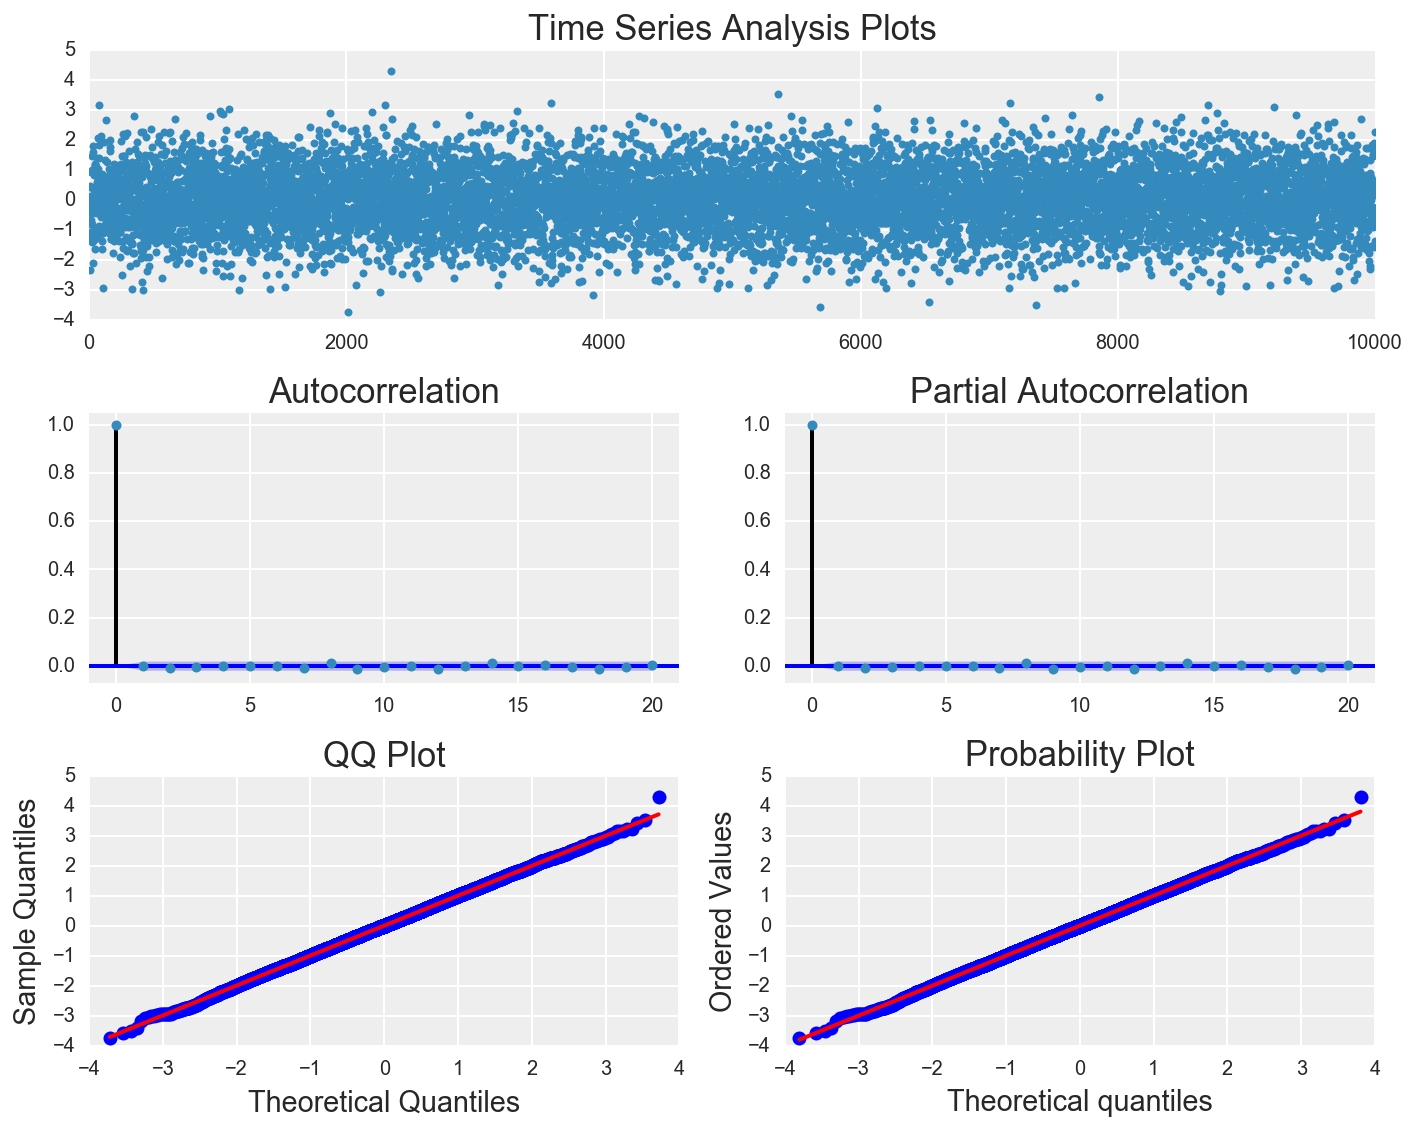

In [208]:
tsplot(bestFit_bic_serma6[1].resid,lags=20)

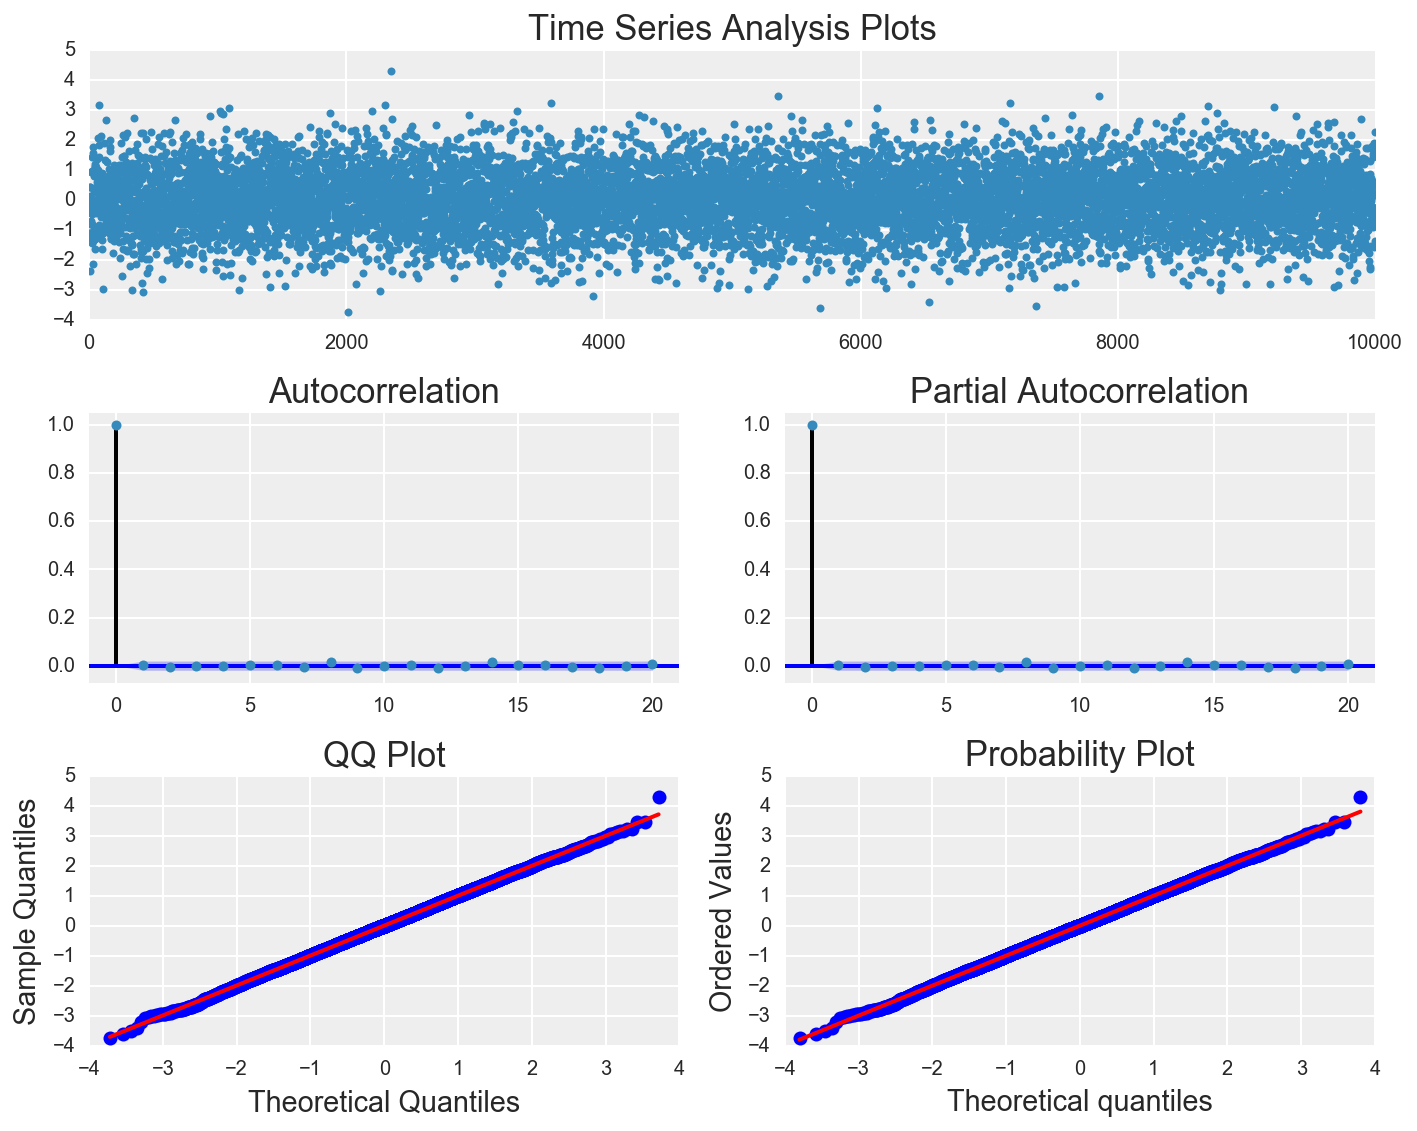

In [209]:
tsplot(bestFit_aic_serma6[1].resid,lags=20)

In [ ]:
# The tsplot figures show no obvious problems with either model.

In [210]:
# Why did ARIMA(0,0,6) fail to fit?
tmp_mdl_arima006 = smt.ARIMA(ser_MA6[:10000], order=(0,0,6)).fit(method='mle', trend='nc')

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [ ]:
# ValueError "The computed initial MA coefficients are not invertible"
    # This is coming from class ARMA, method _fit_start_params_hr
            # Initial params are being estimated, and then the characteristic MA polynomial has a root with abs(root)>1
        
# The relevant test in the ARMA class code is here:
        # elif q and not np.all(np.abs(np.roots(np.r_[1, start_params[k + p:]])) < 1):
    

In [219]:
print('AIC (ARIMA(1,0,7)) params, theta_roots and abs(theta_roots):')
print('AR params: ' + str(bestFit_aic_serma6[1].arparams) + '. MA params: ' + str(bestFit_aic_serma6[1].maparams))
print(np.roots(np.r_[1,bestFit_aic_serma6[1].maparams]))
print(np.abs(np.roots(np.r_[1,bestFit_aic_serma6[1].maparams])))
print('BIC (ARIMA(1,0,6)) params, theta_roots and abs(theta_roots):')
print('AR params: ' + str(bestFit_bic_serma6[1].arparams) + '. MA params: ' + str(bestFit_bic_serma6[1].maparams))
print(np.roots(np.r_[1,bestFit_bic_serma6[1].maparams]))
print(np.abs(np.roots(np.r_[1,bestFit_bic_serma6[1].maparams])))
print('underlying model:')
print(np.roots([1,1,1,1,1,1,1]))
print(np.abs(np.roots([1,1,1,1,1,1,1])))

AIC (ARIMA(1,0,7)) params, theta_roots and abs(theta_roots):
AR params: [ 0.98900476]. MA params: [ 0.00681426  0.00605821  0.00739434  0.00654461  0.00809406  0.00706087
 -0.99202714]
[-0.90095819+0.43351049j -0.90095819-0.43351049j -0.22249129+0.97481332j
 -0.22249129-0.97481332j  0.62361261+0.78156788j  0.62361261-0.78156788j
  0.99285950+0.j        ]
[ 0.99982849  0.99982849  0.99988168  0.99988168  0.99987051  0.99987051
  0.9928595 ]
BIC (ARIMA(1,0,6)) params, theta_roots and abs(theta_roots):
AR params: [-0.00122994]. MA params: [ 0.99986428  0.99878385  0.99917885  0.99877061  0.99984025  0.99994873]
[ 0.62370197+0.78165335j  0.62370197-0.78165335j -0.90110575+0.43357566j
 -0.90110575-0.43357566j -0.22252836+0.97491761j -0.22252836-0.97491761j]
[ 0.99999305  0.99999305  0.99998971  0.99998971  0.99999161  0.99999161]
underlying model:
[ 0.62348980+0.78183148j  0.62348980-0.78183148j -0.90096887+0.43388374j
 -0.90096887-0.43388374j -0.22252093+0.97492791j -0.22252093-0.97492791j

In [ ]:
# So the generative polynomial has unit roots. But why do we care? It's a moving average model, not AR.
    # Unit root tests should only be applied to the AR coeffs, not MA
        # Since there is finite impulse response, the series should be stable regardless of the coefficients
# Also: Invertibility probably isn't the actual issue, b/c probability of a random initial mtx having det(0) => basically zero
    # Recall: it is generating initial guesses from the data, which are noisy
# Bug in statsmodels?

In [231]:
# Regardless, ARIMA(1,0,6) looked pretty good, with a minimal phi_1 coeff
# Feed the six-dimensional theta_vector from bestFit_bic into another MA(6) attempt
tmp_mdl_serma6_006 = smt.ARIMA(ser_MA6[:10000], order=(0,0,6)).fit(method='mle', trend='nc',
                                                                   start_params=bestFit_bic_serma6[1].maparams)
# No error this time

In [232]:
print((tmp_mdl_serma6_006.aic,tmp_mdl_serma6_006.bic))
print(tmp_mdl_serma6_006.maparams)

(28358.51185330034, 28408.984235904172)
[ 0.99987583  0.9987983   0.99919727  0.99878506  0.9998518   0.99994873]


In [233]:
print((best_aic_serma6,best_bic_serma6))
# Our new model does better under bic but doesn't beat the previous best AIC

(28356.168897164862, 28418.179825593168)


In [237]:
# BIC improvement is about as expected, for one less parameter:
# parsimony contribution to BIC is k*ln(n), where k is the number of parameters
print(best_bic_serma6 - tmp_mdl_serma6_006.bic)
print(1 * np.log(10000)) # one less parameter
# showing that the AR-1 term wasn't useful in maximizing log-likelihood

9.195589689
9.21034037198


In [163]:
# Let's look at the BMW data built into R:
order=1
bmw = np.array(pd.read_csv('bmwData.csv')['x'])
n=len(bmw)
(bmw_X,bmw_Y) = (bmw[:-1].reshape(n-order,1),bmw[1:].reshape(n-order,1))
bmw_xX = np.concatenate((np.ones((bmw_X.shape[0],1)),bmw_X),axis=1) # add intercept as trivial feature of ones
bmw_beta = np.dot(np.linalg.inv(np.dot(bmw_xX.T,bmw_xX)),np.dot(bmw_xX.T,bmw_Y)) 
bmw_beta

array([[ 0.00030541],
       [ 0.08099462]])

In [ ]:
# (81116./80995) # R's result for ARIMA(1,0,0) fit is somewhat higher than my regression slope
# (81116./80995 - 1) * len(bmw)   # factor of 9.18 ? ::: so the discrepancy is not an obvious linear function of n

In [164]:
# R command:  myACF[[1]][1:10] actually does produce 0.080994606 for the lag=1 term in ACF of the bmw series
    # so actually they do agree
    # why would ARIMA fit give a different coeff? does it assume zero-intercept?
bmw_xX0 = bmw_X
bmw_beta_zeroIntercept = np.dot(np.linalg.inv(np.dot(bmw_xX0.T,bmw_xX0)),np.dot(bmw_xX0.T,bmw_Y)) 
bmw_beta_zeroIntercept
# Answer 0.08147. So that does make a difference but doesn't get 0.81116 either

array([[ 0.08147237]])

In [179]:
# Check ACF:
print(rek_acf(bmw,lags=5,demean=True,unbiased=True))
print(rek_acf(bmw,lags=5,demean=True,unbiased=False))

[ 1.          0.08100779 -0.02055516  0.00758861  0.01349489  0.00971053]
[ 1.          0.08099461 -0.02054847  0.00758491  0.01348611  0.00970263]


In [180]:
sm_acf(bmw,nlags=5)

array([ 1.        ,  0.08099461, -0.02054847,  0.00758491,  0.01348611,
        0.00970263])

In [181]:
print(sm_pacf(bmw,nlags=5,method='ywunbiased'))
print(sm_pacf(bmw,nlags=5,method='ywmle'))

[ 1.          0.08100779 -0.02729655  0.0115951   0.01142572  0.00815185]
[ 1.          0.08099461 -0.02728761  0.01158939  0.01141828  0.00814521]


In [ ]:
# Fit ARIMA(p, d, q) model to BMW Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(bmw, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [ ]:
# Interesting. The BMW acf/pacf suggest that AR(1) would be a decent fit
        # but Akaike criterion likes the more complicated models better
    # ARIMA(2,0,0) is pretty good though...

In [ ]:
# What about BIC as selection criterion?

In [ ]:
# Fit ARIMA(p, d, q) model to BMW Returns
# pick best order and final model based on bic

best_bic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(bmw, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_bic = tmp_mdl.bic
                print((i,d,j,tmp_bic))
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('bic: {:6.5f} | order: {}'.format(best_bic, best_order))
# bic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# BIC prefers (0,0,1) = MA(1) model 

# the MA(1) model could be more appropriate than AR(1)
    # AR(1) gets correlations all lags: Cor at lag k ~=> phi^k
    # MA(1) eliminates these correlations

# BIC chooses a more parsimonious model than AIC (tradeoff => goodness of fit)

In [ ]:
# What does the analysis look like with our simulated AR(1) series from above?

In [ ]:
# Fit ARIMA(p, d, q) model to ser_AR1 data
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_AR1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# So it does identify (1,0,0) as the best model for the simulated AR1 series

In [ ]:
# Let's simulate the MA(1) process:
def rek_generateSeries_MA1(n,mu,theta):
    epsilon=np.random.normal(size=n)
    ser = np.zeros(n) + mu
    ser[0] = mu + epsilon[0]
    for i in range(1,n):
        ser[i] = mu + epsilon[i] + theta*epsilon[i-1]
    return ser

In [ ]:
np.random.seed(4)
ser_MA1 = rek_generateSeries_MA1(1000,0.0,1.0)
plt.plot(ser_MA1,'.')

In [ ]:
# No long-range correlation, only at lag=1. So the above plot looks a lot like white noise.
# But let's look at the autocorrelations using TSPLOT:
tsplot(ser_MA1, lags=30)

In [ ]:
# The first auto-correlation coefficient is much too high for white noise.
# But the other coefficients are near zero, unlike an AR model.

# The pacf figure shows the pitfalls of trying to fit AR(p) models when the true model should be MA:
    # In order to match the correlation at lag=1, it chooses a large phi.
    # But then that model assumes proportional positive correlations at lag=2, ~ phi^2
        # Since no such correlations exist, the residuals will demonstrate negative correlation at lag=2
    # The same effect continues for higher p, and the sign will reverse each time.
        # until the effect drops enough that its systematic bias gets lost in the noise for high p

In [ ]:
# Now let's see if ARIMA can identify MA1 as the model underlying this data:

# Fit ARIMA(p, d, q) model to ser_MA1 data
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ser_MA1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print((i,d,j,tmp_aic))
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [ ]:
# Yes, MA1 was identified as best model, even using AIC rather than BIC

In [ ]:
# A little strange that MA(q) models gave errors for q>=2
MA1_mdl_002 = smt.ARIMA(ser_MA1, order=(0,0,2)).fit(method='mle', trend='nc')

In [ ]:
rek_LjungBox(bmw_Y - (bmw_beta[1]*bmw_X+bmw_beta[0]),lags=30)

In [ ]:
best_mdl.bic

In [ ]:
len(np.diff(bmw))

Are there any patterns? Given recent history, can we learn anything about the next roll?

Let's consider all consecutive pairs:

In [14]:
import numpy as np
np.random.seed(67)
N=540000
rollSequence = 1+np.random.randint(6,size=N)
print(rollSequence[:20])
d = {(k1,k2):0 for k1 in range(1,7) for k2 in range(1,7)}
for jj in range(N-1):
    d[(rollSequence[jj],rollSequence[jj+1])] += 1
d

{(1, 1): 15138,
 (1, 2): 14965,
 (1, 3): 15116,
 (1, 4): 15001,
 (1, 5): 14845,
 (1, 6): 15032,
 (2, 1): 15113,
 (2, 2): 15079,
 (2, 3): 14943,
 (2, 4): 14966,
 (2, 5): 14908,
 (2, 6): 15120,
 (3, 1): 14938,
 (3, 2): 14798,
 (3, 3): 14879,
 (3, 4): 15050,
 (3, 5): 15068,
 (3, 6): 14877,
 (4, 1): 15208,
 (4, 2): 15232,
 (4, 3): 14971,
 (4, 4): 15079,
 (4, 5): 14760,
 (4, 6): 15114,
 (5, 1): 14768,
 (5, 2): 15141,
 (5, 3): 14804,
 (5, 4): 14919,
 (5, 5): 14992,
 (5, 6): 14989,
 (6, 1): 14933,
 (6, 2): 14914,
 (6, 3): 14897,
 (6, 4): 15348,
 (6, 5): 15040,
 (6, 6): 15054}

As expected, each possible outcome is equally likely to follow any preceding outcome. Because these are independent trials from a fair die, there is no correlation.